# import and params

In [2]:
import torch
import sys
from tqdm import tqdm
import os
sys.path.append("../")
import transformers
print(transformers.__version__)
# from diffusion_prior import DiffusionPriorUNet, Pipe
from diffusion_prior_v2 import DiffusionPriorUNet, Pipe
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
proxy = 'http://127.0.0.1:7897'
os.environ['http_proxy'] = proxy
os.environ['https_proxy'] = proxy


4.28.1


In [3]:
import cv2
import numpy as np

from skimage.morphology import skeletonize
from PIL import Image

def process_controlimg(image_path, mode):
    # mode: edge, background, skeleton
    # 读取图像
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise ValueError("无法加载图像，请检查路径是否正确")
    
    # 增强对比度
    img = cv2.equalizeHist(img)
    
    # 3. 前景(影子)提取
    blurred = cv2.GaussianBlur(img, (5, 5), 0)
    ret, thresh = cv2.threshold(blurred, 0, 255, 
                            cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    kernel = np.ones((3, 3), np.uint8)
    opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)
    shadow = cv2.dilate(opening, kernel, iterations=3)
    if mode=='edge':
        # 1. 边缘提取
        v = np.mean(shadow)
        lower = int(max(0, (1.0 - 0.33) * v))
        upper = int(min(255, (1.0 + 0.33) * v))
        edges = cv2.Canny(shadow, lower, upper)
        output = edges
    elif mode=='skeleton':
    # 2. 骨架提取
        skeleton = skeletonize(shadow // 255)
        skeleton = (skeleton * 255).astype(np.uint8)
        output = skeleton
    elif mode=='shadow':
        output = shadow
    
    # 转换为PIL图像
    output = Image.fromarray(output).convert("RGB")
    
    return output

# 07142-baseline

In [3]:
from custom_pipeline_tang2 import Generator4Embeds
from eegdatasets_tang_clip2 import EEGDataset

## params
mode = 'edge'
subjects = ['sub-01', 'sub-02', 'sub-03', 'sub-04', 'sub-05', 'sub-06', 'sub-07', 'sub-08', 'sub-09', 'sub-10', 'sub-11', 'sub-12',
    'sub-13', 'sub-14', 'sub-15', 'sub-16', 'sub-17', 'sub-18', 'sub-19', 'sub-20', 'sub-21', 'sub-22', 'sub-23', 'sub-24']
# subjects = ['sub-01']
date_code = '07142' ######## change date
data_path = "/home/nncc/lyx/project/EEG_Image_decode-main/myEEG/splitv3/whiten/Preprocessed_data_250Hz"
expname = f'{date_code}-single'
control_scale = 0.0 ######## no control
n_steps = 4

for sub in subjects:
    directory = f"generated_imgs/{sub}-{expname}-3p"
    emb_eeg_test = torch.load(f'eeg_features/{expname}/ATM_S_eeg_features_{sub}_test.pt')

    # 读取UNet Diffusion，把EEG Embedding转换为Image Embedding
    diffusion_prior = DiffusionPriorUNet(cond_dim=1024, dropout=0.1)
    pipe = Pipe(diffusion_prior, device=device)
    pipe.diffusion_prior.load_state_dict(torch.load(f'/home/nncc/lyx/project/EEG_Image_decode-main/Generation/fintune_ckpts/ATMS/{sub}-{expname}/diffusion_prior.pt', map_location=device))

    # generator
    # generator = Generator4Embeds(num_inference_steps=n_steps, controlnet_scale=control_scale, device=device, img2img_strength=0.0, cpu_offload=False)
    generator = Generator4Embeds(num_inference_steps=n_steps, controlnet_scale=control_scale, device=device, img2img_strength=0.0, cpu_offload=True)
    
    save_dir = f'dataset_features/{sub}-{expname}'
    # test_dataset = EEGDataset(data_path, subjects=[sub], train=False, multilabel=True, textmode='whole', featpth=save_dir)
    test_dataset = EEGDataset(data_path, subjects=[sub], train=False, multilabel=False, textmode='picture', featpth=save_dir)
    texts = test_dataset.text
    images = test_dataset.img

    step = 1 # too much to draw

    for k in tqdm(range(0, emb_eeg_test.shape[0], step),):
        eeg_embeds = emb_eeg_test[k:k+1]
        h = pipe.generate(c_embeds=eeg_embeds, num_inference_steps=10, guidance_scale=5.0)
        # control_pth = f'/home/nncc/lyx/project/EEG_Image_decode-main/Generation/vae/{sub}/0707_vae_imgs/epoch_100'
        control_pth = f'/home/nncc/lyx/project/EEG_Image_decode-main/Generation/vae/sub-01/05-04_19-39_vae_imgs/epoch_100'
        control_pth = f'{control_pth}/reconstructed_image_{k}.png'
        control_image = process_controlimg(control_pth, mode=mode)

        for j in range(3):
            ################ dif
            image = generator.generate(ip_embeds=h, control_image=control_image)
            path = f'{directory}/dif/{texts[k]}-{k}/{j}.png'
            os.makedirs(os.path.dirname(path), exist_ok=True)
            image.save(path)

            ################ eeg
            image = generator.generate(ip_embeds=eeg_embeds, control_image=control_image)
            path = f'{directory}/eeg/{texts[k]}-{k}/{j}.png'
            os.makedirs(os.path.dirname(path), exist_ok=True)
            image.save(path)

            ################ img
            image = generator.generate(ip_embeds=test_dataset.img_features[k].unsqueeze(0), control_image=control_image)
            path = f'{directory}/img/{texts[k]}-{k}/{j}.png'
            os.makedirs(os.path.dirname(path), exist_ok=True)
            image.save(path)

/home/nncc/miniconda3/envs/BCI/lib/python3.10/site-packages/diffusers/utils/outputs.py:63: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(


1


/home/nncc/miniconda3/envs/BCI/lib/python3.10/site-packages/diffusers/utils/outputs.py:63: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(
/home/nncc/miniconda3/envs/BCI/lib/python3.10/site-packages/huggingface_hub/file_download.py:1142: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Loading pipeline components...: 100%|██████████| 7/7 [00:01<00:00,  6.98it/s]


self.subjects ['sub-01']
exclude_subject None
Data tensor shape: torch.Size([69, 63, 250]), label tensor shape: torch.Size([69]), text length: 69, image length: 69


10it [00:00, 40.11it/s]00:00<?, ?it/s]
100%|██████████| 4/4 [00:01<00:00,  2.69it/s]
10it [00:00, 820.19it/s]0:29<33:41, 29.73s/it]
100%|██████████| 4/4 [00:01<00:00,  2.82it/s]
10it [00:00, 828.91it/s]0:57<32:06, 28.75s/it]
100%|██████████| 4/4 [00:01<00:00,  2.75it/s]
10it [00:00, 864.06it/s]1:25<31:04, 28.24s/it]
100%|██████████| 4/4 [00:01<00:00,  2.86it/s]
10it [00:00, 779.99it/s]1:52<30:15, 27.93s/it]
100%|██████████| 4/4 [00:01<00:00,  2.83it/s]
10it [00:00, 812.20it/s]2:20<29:39, 27.80s/it]
100%|██████████| 4/4 [00:01<00:00,  2.85it/s]
10it [00:00, 855.67it/s]2:47<29:04, 27.69s/it]
100%|██████████| 4/4 [00:01<00:00,  2.84it/s]
10it [00:00, 859.31it/s]3:15<28:33, 27.64s/it]
100%|██████████| 4/4 [00:01<00:00,  2.87it/s]
10it [00:00, 846.48it/s]3:43<28:04, 27.61s/it]
100%|██████████| 4/4 [00:01<00:00,  2.86it/s]
10it [00:00, 846.84it/s]4:10<27:34, 27.58s/it]
100%|██████████| 4/4 [00:01<00:00,  2.82it/s]
10it [00:00, 848.41it/s]04:38<27:05, 27.56s/it]
100%|██████████| 4/4 [00:01<00

self.subjects ['sub-02']
exclude_subject None


/home/nncc/lyx/project/EEG_Image_decode-main/Generation/eegdatasets_tang_clip2.py:325: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at /pytorch/aten/src/ATen/native/Copy.cpp:307.)
  preprocessed_eeg_data = torch.from_numpy(data['preprocessed_eeg_data']).float().detach()


Data tensor shape: torch.Size([51, 63, 250]), label tensor shape: torch.Size([51]), text length: 51, image length: 51


10it [00:00, 100.47it/s]0:00<?, ?it/s]
100%|██████████| 4/4 [00:01<00:00,  2.81it/s]
10it [00:00, 794.38it/s]0:29<24:44, 29.70s/it]
100%|██████████| 4/4 [00:01<00:00,  2.81it/s]
10it [00:00, 826.11it/s]0:57<23:26, 28.70s/it]
100%|██████████| 4/4 [00:01<00:00,  2.84it/s]
10it [00:00, 777.69it/s]1:25<22:35, 28.25s/it]
100%|██████████| 4/4 [00:01<00:00,  2.84it/s]
10it [00:00, 815.62it/s]1:53<21:56, 28.00s/it]
100%|██████████| 4/4 [00:01<00:00,  2.85it/s]
10it [00:00, 803.37it/s]2:20<21:24, 27.93s/it]
100%|██████████| 4/4 [00:01<00:00,  2.83it/s]
10it [00:00, 837.57it/s]2:48<20:50, 27.79s/it]
100%|██████████| 4/4 [00:01<00:00,  2.83it/s]
10it [00:00, 836.47it/s]3:15<20:20, 27.73s/it]
100%|██████████| 4/4 [00:01<00:00,  2.84it/s]
10it [00:00, 834.12it/s]3:43<19:53, 27.77s/it]
100%|██████████| 4/4 [00:01<00:00,  2.84it/s]
10it [00:00, 766.46it/s]4:11<19:24, 27.73s/it]
100%|██████████| 4/4 [00:01<00:00,  2.85it/s]
10it [00:00, 813.23it/s]04:39<18:55, 27.70s/it]
100%|██████████| 4/4 [00:01<00

self.subjects ['sub-03']
exclude_subject None
Data tensor shape: torch.Size([35, 63, 250]), label tensor shape: torch.Size([35]), text length: 35, image length: 35


10it [00:00, 68.11it/s]00:00<?, ?it/s]
100%|██████████| 4/4 [00:01<00:00,  2.85it/s]
10it [00:00, 821.78it/s]0:34<19:48, 34.95s/it]
100%|██████████| 4/4 [00:01<00:00,  2.85it/s]
10it [00:00, 825.52it/s]1:03<17:01, 30.95s/it]
100%|██████████| 4/4 [00:01<00:00,  2.86it/s]
10it [00:00, 817.35it/s]1:30<15:38, 29.34s/it]
100%|██████████| 4/4 [00:01<00:00,  2.83it/s]
10it [00:00, 809.43it/s]1:57<14:42, 28.48s/it]
100%|██████████| 4/4 [00:01<00:00,  2.88it/s]
10it [00:00, 828.91it/s]2:24<13:59, 28.00s/it]
100%|██████████| 4/4 [00:01<00:00,  2.82it/s]
10it [00:00, 827.15it/s]2:52<13:25, 27.76s/it]
100%|██████████| 4/4 [00:01<00:00,  2.86it/s]
10it [00:00, 818.74it/s]3:19<12:50, 27.53s/it]
100%|██████████| 4/4 [00:01<00:00,  2.80it/s]
10it [00:00, 820.02it/s]3:46<12:21, 27.45s/it]
100%|██████████| 4/4 [00:01<00:00,  2.82it/s]
10it [00:00, 801.43it/s]4:13<11:50, 27.34s/it]
100%|██████████| 4/4 [00:01<00:00,  2.81it/s]
10it [00:00, 794.30it/s]04:40<11:21, 27.28s/it]
100%|██████████| 4/4 [00:01<00

self.subjects ['sub-04']
exclude_subject None
Data tensor shape: torch.Size([48, 63, 250]), label tensor shape: torch.Size([48]), text length: 48, image length: 48


10it [00:00, 176.27it/s]0:00<?, ?it/s]
100%|██████████| 4/4 [00:01<00:00,  2.83it/s]
10it [00:00, 607.43it/s]0:40<31:29, 40.20s/it]
100%|██████████| 4/4 [00:01<00:00,  2.83it/s]
10it [00:00, 834.02it/s]1:09<25:43, 33.54s/it]
100%|██████████| 4/4 [00:01<00:00,  2.85it/s]
10it [00:00, 822.91it/s]1:36<23:10, 30.91s/it]
100%|██████████| 4/4 [00:01<00:00,  2.80it/s]
10it [00:00, 796.65it/s]2:04<21:45, 29.66s/it]
100%|██████████| 4/4 [00:01<00:00,  2.80it/s]
10it [00:00, 806.40it/s]2:32<20:46, 28.98s/it]
100%|██████████| 4/4 [00:01<00:00,  2.81it/s]
10it [00:00, 816.65it/s]3:00<20:00, 28.58s/it]
100%|██████████| 4/4 [00:01<00:00,  2.85it/s]
10it [00:00, 798.93it/s]3:28<19:21, 28.33s/it]
100%|██████████| 4/4 [00:01<00:00,  2.83it/s]
10it [00:00, 845.11it/s]3:55<18:46, 28.16s/it]
100%|██████████| 4/4 [00:01<00:00,  2.83it/s]
10it [00:00, 836.04it/s]4:23<18:13, 28.04s/it]
100%|██████████| 4/4 [00:01<00:00,  2.79it/s]
10it [00:00, 817.87it/s]04:51<17:45, 28.03s/it]
100%|██████████| 4/4 [00:01<00

self.subjects ['sub-05']
exclude_subject None
Data tensor shape: torch.Size([70, 63, 250]), label tensor shape: torch.Size([70]), text length: 70, image length: 70


10it [00:00, 21.72it/s]00:00<?, ?it/s]
100%|██████████| 4/4 [00:01<00:00,  2.85it/s]
10it [00:00, 743.71it/s]0:37<42:39, 37.10s/it]
100%|██████████| 4/4 [00:01<00:00,  2.82it/s]
10it [00:00, 788.39it/s]1:04<35:33, 31.37s/it]
100%|██████████| 4/4 [00:01<00:00,  2.86it/s]
10it [00:00, 769.89it/s]1:31<32:57, 29.51s/it]
100%|██████████| 4/4 [00:01<00:00,  2.82it/s]
10it [00:00, 804.93it/s]1:58<31:22, 28.53s/it]
100%|██████████| 4/4 [00:01<00:00,  2.85it/s]
10it [00:00, 858.22it/s]2:26<30:24, 28.06s/it]
100%|██████████| 4/4 [00:01<00:00,  2.84it/s]
10it [00:00, 812.72it/s]2:53<29:32, 27.70s/it]
100%|██████████| 4/4 [00:01<00:00,  2.86it/s]
10it [00:00, 800.00it/s]3:20<28:51, 27.49s/it]
100%|██████████| 4/4 [00:01<00:00,  2.81it/s]
10it [00:00, 781.91it/s]3:47<28:15, 27.34s/it]
100%|██████████| 4/4 [00:01<00:00,  2.85it/s]
10it [00:00, 812.82it/s]4:13<27:38, 27.19s/it]
100%|██████████| 4/4 [00:01<00:00,  2.84it/s]
10it [00:00, 790.35it/s]04:40<27:04, 27.08s/it]
100%|██████████| 4/4 [00:01<00

self.subjects ['sub-06']
exclude_subject None
Data tensor shape: torch.Size([65, 63, 250]), label tensor shape: torch.Size([65]), text length: 65, image length: 65


10it [00:00, 70.73it/s]00:00<?, ?it/s]
100%|██████████| 4/4 [00:01<00:00,  2.85it/s]
10it [00:00, 811.47it/s]0:32<34:38, 32.48s/it]
100%|██████████| 4/4 [00:01<00:00,  2.84it/s]
10it [00:00, 821.03it/s]1:00<31:17, 29.80s/it]
100%|██████████| 4/4 [00:01<00:00,  2.85it/s]
10it [00:00, 781.99it/s]1:28<29:45, 28.80s/it]
100%|██████████| 4/4 [00:01<00:00,  2.86it/s]
10it [00:00, 816.93it/s]1:55<28:46, 28.30s/it]
100%|██████████| 4/4 [00:01<00:00,  2.84it/s]
10it [00:00, 825.02it/s]2:23<28:02, 28.04s/it]
100%|██████████| 4/4 [00:01<00:00,  2.84it/s]
10it [00:00, 835.25it/s]2:50<27:25, 27.89s/it]
100%|██████████| 4/4 [00:01<00:00,  2.83it/s]
10it [00:00, 830.41it/s]3:18<26:52, 27.81s/it]
100%|██████████| 4/4 [00:01<00:00,  2.85it/s]
10it [00:00, 777.39it/s]3:45<26:18, 27.70s/it]
100%|██████████| 4/4 [00:01<00:00,  2.86it/s]
10it [00:00, 813.18it/s]4:13<25:47, 27.64s/it]
100%|██████████| 4/4 [00:01<00:00,  2.83it/s]
10it [00:00, 806.46it/s]04:40<25:18, 27.60s/it]
100%|██████████| 4/4 [00:01<00

self.subjects ['sub-07']
exclude_subject None
Data tensor shape: torch.Size([65, 63, 250]), label tensor shape: torch.Size([65]), text length: 65, image length: 65


10it [00:00, 23.09it/s]00:00<?, ?it/s]
100%|██████████| 4/4 [00:01<00:00,  2.82it/s]
10it [00:00, 786.44it/s]0:36<38:34, 36.17s/it]
100%|██████████| 4/4 [00:01<00:00,  2.85it/s]
10it [00:00, 485.15it/s]1:03<32:42, 31.15s/it]
100%|██████████| 4/4 [00:01<00:00,  2.84it/s]
10it [00:00, 801.36it/s]1:31<30:28, 29.49s/it]
100%|██████████| 4/4 [00:01<00:00,  2.84it/s]
10it [00:00, 781.59it/s]1:58<29:06, 28.63s/it]
100%|██████████| 4/4 [00:01<00:00,  2.86it/s]
10it [00:00, 840.66it/s]2:25<28:07, 28.12s/it]
100%|██████████| 4/4 [00:01<00:00,  2.83it/s]
10it [00:00, 805.16it/s]2:53<27:21, 27.82s/it]
100%|██████████| 4/4 [00:01<00:00,  2.84it/s]
10it [00:00, 825.36it/s]3:20<26:41, 27.61s/it]
100%|██████████| 4/4 [00:01<00:00,  2.85it/s]
10it [00:00, 836.50it/s]3:47<26:05, 27.47s/it]
100%|██████████| 4/4 [00:01<00:00,  2.83it/s]
10it [00:00, 830.44it/s]4:14<25:35, 27.42s/it]
100%|██████████| 4/4 [00:01<00:00,  2.85it/s]
10it [00:00, 802.15it/s]04:42<25:09, 27.45s/it]
100%|██████████| 4/4 [00:01<00

self.subjects ['sub-08']
exclude_subject None
Data tensor shape: torch.Size([67, 63, 250]), label tensor shape: torch.Size([67]), text length: 67, image length: 67


10it [00:00, 108.70it/s]0:00<?, ?it/s]
100%|██████████| 4/4 [00:01<00:00,  2.86it/s]
10it [00:00, 801.20it/s]0:31<34:53, 31.71s/it]
100%|██████████| 4/4 [00:01<00:00,  2.82it/s]
10it [00:00, 759.22it/s]0:59<31:46, 29.34s/it]
100%|██████████| 4/4 [00:01<00:00,  2.81it/s]
10it [00:00, 772.86it/s]1:27<30:35, 28.67s/it]
100%|██████████| 4/4 [00:01<00:00,  2.86it/s]
10it [00:00, 778.35it/s]1:55<29:43, 28.31s/it]
100%|██████████| 4/4 [00:01<00:00,  2.84it/s]
10it [00:00, 839.47it/s]2:22<29:00, 28.07s/it]
100%|██████████| 4/4 [00:01<00:00,  2.84it/s]
10it [00:00, 771.45it/s]2:50<28:19, 27.87s/it]
100%|██████████| 4/4 [00:01<00:00,  2.83it/s]
10it [00:00, 796.79it/s]3:17<27:48, 27.81s/it]
100%|██████████| 4/4 [00:01<00:00,  2.84it/s]
10it [00:00, 834.70it/s]3:45<27:14, 27.70s/it]
100%|██████████| 4/4 [00:01<00:00,  2.85it/s]
10it [00:00, 810.46it/s]4:12<26:44, 27.67s/it]
100%|██████████| 4/4 [00:01<00:00,  2.85it/s]
10it [00:00, 818.66it/s]04:40<26:12, 27.58s/it]
100%|██████████| 4/4 [00:01<00

self.subjects ['sub-09']
exclude_subject None
Data tensor shape: torch.Size([52, 63, 250]), label tensor shape: torch.Size([52]), text length: 52, image length: 52


10it [00:00, 94.32it/s]00:00<?, ?it/s]
100%|██████████| 4/4 [00:01<00:00,  2.85it/s]
10it [00:00, 793.79it/s]0:33<28:03, 33.01s/it]
100%|██████████| 4/4 [00:01<00:00,  2.85it/s]
10it [00:00, 851.07it/s]1:00<24:51, 29.82s/it]
100%|██████████| 4/4 [00:01<00:00,  2.86it/s]
10it [00:00, 821.12it/s]1:27<23:23, 28.64s/it]
100%|██████████| 4/4 [00:01<00:00,  2.85it/s]
10it [00:00, 838.27it/s]1:54<22:26, 28.05s/it]
100%|██████████| 4/4 [00:01<00:00,  2.83it/s]
10it [00:00, 765.13it/s]2:22<21:42, 27.70s/it]
100%|██████████| 4/4 [00:01<00:00,  2.83it/s]
10it [00:00, 822.96it/s]2:49<21:05, 27.51s/it]
100%|██████████| 4/4 [00:01<00:00,  2.78it/s]
10it [00:00, 715.14it/s]3:16<20:31, 27.37s/it]
100%|██████████| 4/4 [00:01<00:00,  2.81it/s]
10it [00:00, 693.55it/s]3:43<20:00, 27.27s/it]
100%|██████████| 4/4 [00:01<00:00,  2.85it/s]
10it [00:00, 806.95it/s]4:10<19:28, 27.18s/it]
100%|██████████| 4/4 [00:01<00:00,  2.85it/s]
10it [00:00, 735.79it/s]04:37<19:00, 27.16s/it]
100%|██████████| 4/4 [00:01<00

self.subjects ['sub-10']
exclude_subject None
Data tensor shape: torch.Size([71, 63, 250]), label tensor shape: torch.Size([71]), text length: 71, image length: 71


10it [00:00, 38.76it/s]00:00<?, ?it/s]
100%|██████████| 4/4 [00:01<00:00,  2.79it/s]
10it [00:00, 813.61it/s]0:30<36:05, 30.93s/it]
100%|██████████| 4/4 [00:01<00:00,  2.83it/s]
10it [00:00, 828.21it/s]0:58<33:28, 29.11s/it]
100%|██████████| 4/4 [00:01<00:00,  2.83it/s]
10it [00:00, 842.08it/s]1:26<32:15, 28.46s/it]
100%|██████████| 4/4 [00:01<00:00,  2.85it/s]
10it [00:00, 788.06it/s]1:53<31:17, 28.02s/it]
100%|██████████| 4/4 [00:01<00:00,  2.83it/s]
10it [00:00, 856.77it/s]2:21<30:38, 27.86s/it]
100%|██████████| 4/4 [00:01<00:00,  2.85it/s]
10it [00:00, 823.46it/s]2:48<30:00, 27.70s/it]
100%|██████████| 4/4 [00:01<00:00,  2.83it/s]
10it [00:00, 860.33it/s]3:16<29:30, 27.67s/it]
100%|██████████| 4/4 [00:01<00:00,  2.85it/s]
10it [00:00, 802.72it/s]3:43<29:00, 27.62s/it]
100%|██████████| 4/4 [00:01<00:00,  2.84it/s]
10it [00:00, 779.68it/s]4:11<28:30, 27.59s/it]
100%|██████████| 4/4 [00:01<00:00,  2.85it/s]
10it [00:00, 848.59it/s]04:38<28:00, 27.54s/it]
100%|██████████| 4/4 [00:01<00

self.subjects ['sub-11']
exclude_subject None
Data tensor shape: torch.Size([61, 63, 250]), label tensor shape: torch.Size([61]), text length: 61, image length: 61


10it [00:00, 20.38it/s]00:00<?, ?it/s]
100%|██████████| 4/4 [00:01<00:00,  2.85it/s]
10it [00:00, 799.11it/s]0:38<38:41, 38.70s/it]
100%|██████████| 4/4 [00:01<00:00,  2.85it/s]
10it [00:00, 783.18it/s]1:05<31:23, 31.93s/it]
100%|██████████| 4/4 [00:01<00:00,  2.95it/s]
10it [00:00, 808.12it/s]1:32<28:41, 29.69s/it]
100%|██████████| 4/4 [00:01<00:00,  2.91it/s]
10it [00:00, 795.48it/s]1:59<27:09, 28.58s/it]
100%|██████████| 4/4 [00:01<00:00,  2.85it/s]
10it [00:00, 815.03it/s]2:26<26:07, 28.00s/it]
100%|██████████| 4/4 [00:01<00:00,  2.87it/s]
10it [00:00, 826.25it/s]2:53<25:20, 27.65s/it]
100%|██████████| 4/4 [00:01<00:00,  2.94it/s]
10it [00:00, 825.28it/s]3:20<24:36, 27.34s/it]
100%|██████████| 4/4 [00:01<00:00,  2.91it/s]
10it [00:00, 829.08it/s]3:47<24:00, 27.19s/it]
100%|██████████| 4/4 [00:01<00:00,  2.86it/s]
10it [00:00, 817.03it/s]4:14<23:28, 27.09s/it]
100%|██████████| 4/4 [00:01<00:00,  2.82it/s]
10it [00:00, 828.77it/s]04:40<22:57, 27.00s/it]
100%|██████████| 4/4 [00:01<00

self.subjects ['sub-12']
exclude_subject None
Data tensor shape: torch.Size([69, 63, 250]), label tensor shape: torch.Size([69]), text length: 69, image length: 69


10it [00:00, 37.69it/s]00:00<?, ?it/s]
100%|██████████| 4/4 [00:01<00:00,  2.82it/s]
10it [00:00, 815.74it/s]0:31<35:17, 31.13s/it]
100%|██████████| 4/4 [00:01<00:00,  2.84it/s]
10it [00:00, 814.93it/s]0:59<32:38, 29.24s/it]
100%|██████████| 4/4 [00:01<00:00,  2.81it/s]
10it [00:00, 821.69it/s]1:26<31:27, 28.59s/it]
100%|██████████| 4/4 [00:01<00:00,  2.82it/s]
10it [00:00, 834.65it/s]1:54<30:40, 28.32s/it]
100%|██████████| 4/4 [00:01<00:00,  2.80it/s]
10it [00:00, 827.61it/s]2:22<30:01, 28.14s/it]
100%|██████████| 4/4 [00:01<00:00,  2.82it/s]
10it [00:00, 830.49it/s]2:50<29:31, 28.12s/it]
100%|██████████| 4/4 [00:01<00:00,  2.84it/s]
10it [00:00, 803.08it/s]3:18<28:55, 27.99s/it]
100%|██████████| 4/4 [00:01<00:00,  2.84it/s]
10it [00:00, 792.39it/s]3:46<28:23, 27.93s/it]
100%|██████████| 4/4 [00:01<00:00,  2.78it/s]
10it [00:00, 838.74it/s]4:13<27:50, 27.84s/it]
100%|██████████| 4/4 [00:01<00:00,  2.81it/s]
10it [00:00, 816.57it/s]04:41<27:20, 27.81s/it]
100%|██████████| 4/4 [00:01<00

self.subjects ['sub-13']
exclude_subject None
Data tensor shape: torch.Size([74, 63, 250]), label tensor shape: torch.Size([74]), text length: 74, image length: 74


10it [00:00, 66.44it/s]00:00<?, ?it/s]
100%|██████████| 4/4 [00:01<00:00,  2.81it/s]
10it [00:00, 804.23it/s]0:33<41:05, 33.77s/it]
100%|██████████| 4/4 [00:01<00:00,  2.80it/s]
10it [00:00, 825.21it/s]1:01<36:10, 30.14s/it]
100%|██████████| 4/4 [00:01<00:00,  2.81it/s]
10it [00:00, 821.40it/s]1:28<34:12, 28.91s/it]
100%|██████████| 4/4 [00:01<00:00,  2.84it/s]
10it [00:00, 793.50it/s]1:56<33:02, 28.33s/it]
100%|██████████| 4/4 [00:01<00:00,  2.81it/s]
10it [00:00, 789.03it/s]2:23<32:07, 27.94s/it]
100%|██████████| 4/4 [00:01<00:00,  2.82it/s]
10it [00:00, 840.61it/s]2:50<31:27, 27.76s/it]
100%|██████████| 4/4 [00:01<00:00,  2.83it/s]
10it [00:00, 816.90it/s]3:18<30:49, 27.60s/it]
100%|██████████| 4/4 [00:01<00:00,  2.83it/s]
10it [00:00, 835.64it/s]3:45<30:13, 27.47s/it]
100%|██████████| 4/4 [00:01<00:00,  2.82it/s]
10it [00:00, 784.36it/s]4:12<29:39, 27.37s/it]
100%|██████████| 4/4 [00:01<00:00,  2.82it/s]
10it [00:00, 809.32it/s]04:39<29:08, 27.32s/it]
100%|██████████| 4/4 [00:01<00

self.subjects ['sub-14']
exclude_subject None
Data tensor shape: torch.Size([68, 63, 250]), label tensor shape: torch.Size([68]), text length: 68, image length: 68


10it [00:00, 64.75it/s]00:00<?, ?it/s]
100%|██████████| 4/4 [00:01<00:00,  2.80it/s]
10it [00:00, 786.79it/s]0:31<35:06, 31.44s/it]
100%|██████████| 4/4 [00:01<00:00,  2.83it/s]
10it [00:00, 815.96it/s]0:59<32:10, 29.24s/it]
100%|██████████| 4/4 [00:01<00:00,  2.83it/s]
10it [00:00, 828.70it/s]1:26<30:50, 28.47s/it]
100%|██████████| 4/4 [00:01<00:00,  2.85it/s]
10it [00:00, 735.52it/s]1:54<29:55, 28.06s/it]
100%|██████████| 4/4 [00:01<00:00,  2.85it/s]
10it [00:00, 787.00it/s]2:21<29:13, 27.84s/it]
100%|██████████| 4/4 [00:01<00:00,  2.84it/s]
10it [00:00, 833.31it/s]2:48<28:35, 27.66s/it]
100%|██████████| 4/4 [00:01<00:00,  2.84it/s]
10it [00:00, 801.19it/s]3:16<28:03, 27.59s/it]
100%|██████████| 4/4 [00:01<00:00,  2.83it/s]
10it [00:00, 804.35it/s]3:43<27:32, 27.53s/it]
100%|██████████| 4/4 [00:01<00:00,  2.83it/s]
10it [00:00, 822.17it/s]4:11<27:00, 27.46s/it]
100%|██████████| 4/4 [00:01<00:00,  2.84it/s]
10it [00:00, 802.20it/s]04:38<26:32, 27.45s/it]
100%|██████████| 4/4 [00:01<00

self.subjects ['sub-15']
exclude_subject None
Data tensor shape: torch.Size([62, 63, 250]), label tensor shape: torch.Size([62]), text length: 62, image length: 62


10it [00:00, 36.80it/s]00:00<?, ?it/s]
100%|██████████| 4/4 [00:01<00:00,  2.82it/s]
10it [00:00, 798.93it/s]0:33<34:15, 33.70s/it]
100%|██████████| 4/4 [00:01<00:00,  2.82it/s]
10it [00:00, 765.89it/s]1:01<30:11, 30.19s/it]
100%|██████████| 4/4 [00:01<00:00,  2.83it/s]
10it [00:00, 851.34it/s]1:28<28:23, 28.87s/it]
100%|██████████| 4/4 [00:01<00:00,  2.85it/s]
10it [00:00, 736.71it/s]1:56<27:18, 28.24s/it]
100%|██████████| 4/4 [00:01<00:00,  2.81it/s]
10it [00:00, 838.48it/s]2:23<26:29, 27.89s/it]
100%|██████████| 4/4 [00:01<00:00,  2.83it/s]
10it [00:00, 744.97it/s]2:50<25:48, 27.66s/it]
100%|██████████| 4/4 [00:01<00:00,  2.83it/s]
10it [00:00, 824.19it/s]3:17<25:11, 27.48s/it]
100%|██████████| 4/4 [00:01<00:00,  2.84it/s]
10it [00:00, 734.23it/s]3:44<24:39, 27.39s/it]
100%|██████████| 4/4 [00:01<00:00,  2.81it/s]
10it [00:00, 823.22it/s]4:12<24:10, 27.36s/it]
100%|██████████| 4/4 [00:01<00:00,  2.83it/s]
10it [00:00, 739.20it/s]04:39<23:41, 27.34s/it]
100%|██████████| 4/4 [00:01<00

self.subjects ['sub-16']
exclude_subject None
Data tensor shape: torch.Size([68, 63, 250]), label tensor shape: torch.Size([68]), text length: 68, image length: 68


10it [00:00, 96.06it/s]00:00<?, ?it/s]
100%|██████████| 4/4 [00:01<00:00,  2.83it/s]
10it [00:00, 799.78it/s]0:30<34:10, 30.61s/it]
100%|██████████| 4/4 [00:01<00:00,  2.84it/s]
10it [00:00, 817.46it/s]0:58<32:06, 29.19s/it]
100%|██████████| 4/4 [00:01<00:00,  2.83it/s]
10it [00:00, 797.88it/s]1:26<30:54, 28.53s/it]
100%|██████████| 4/4 [00:01<00:00,  2.84it/s]
10it [00:00, 794.86it/s]1:54<30:05, 28.21s/it]
100%|██████████| 4/4 [00:01<00:00,  2.85it/s]
10it [00:00, 801.37it/s]2:21<29:25, 28.02s/it]
100%|██████████| 4/4 [00:01<00:00,  2.85it/s]
10it [00:00, 827.20it/s]2:49<28:47, 27.86s/it]
100%|██████████| 4/4 [00:01<00:00,  2.81it/s]
10it [00:00, 821.57it/s]3:17<28:22, 27.91s/it]
100%|██████████| 4/4 [00:01<00:00,  2.81it/s]
10it [00:00, 810.87it/s]3:45<27:50, 27.84s/it]
100%|██████████| 4/4 [00:01<00:00,  2.83it/s]
10it [00:00, 777.66it/s]4:12<27:17, 27.75s/it]
100%|██████████| 4/4 [00:01<00:00,  2.83it/s]
10it [00:00, 792.95it/s]04:40<26:47, 27.71s/it]
100%|██████████| 4/4 [00:01<00

self.subjects ['sub-17']
exclude_subject None
Data tensor shape: torch.Size([63, 63, 250]), label tensor shape: torch.Size([63]), text length: 63, image length: 63


10it [00:00, 76.56it/s]00:00<?, ?it/s]
100%|██████████| 4/4 [00:01<00:00,  2.81it/s]
10it [00:00, 787.28it/s]0:33<34:05, 33.00s/it]
100%|██████████| 4/4 [00:01<00:00,  2.83it/s]
10it [00:00, 689.74it/s]1:01<30:39, 30.15s/it]
100%|██████████| 4/4 [00:01<00:00,  2.80it/s]
10it [00:00, 801.07it/s]1:28<29:05, 29.09s/it]
100%|██████████| 4/4 [00:01<00:00,  2.84it/s]
10it [00:00, 723.16it/s]1:56<28:04, 28.55s/it]
100%|██████████| 4/4 [00:01<00:00,  2.84it/s]
10it [00:00, 813.37it/s]2:24<27:17, 28.24s/it]
100%|██████████| 4/4 [00:01<00:00,  2.76it/s]
10it [00:00, 696.71it/s]2:52<26:38, 28.05s/it]
100%|██████████| 4/4 [00:01<00:00,  2.81it/s]
10it [00:00, 823.33it/s]3:19<26:05, 27.95s/it]
100%|██████████| 4/4 [00:01<00:00,  2.80it/s]
10it [00:00, 788.49it/s]3:47<25:31, 27.84s/it]
100%|██████████| 4/4 [00:01<00:00,  2.78it/s]
10it [00:00, 826.95it/s]4:15<24:59, 27.77s/it]
100%|██████████| 4/4 [00:01<00:00,  2.84it/s]
10it [00:00, 779.62it/s]04:42<24:29, 27.73s/it]
100%|██████████| 4/4 [00:01<00

self.subjects ['sub-18']
exclude_subject None
Data tensor shape: torch.Size([69, 63, 250]), label tensor shape: torch.Size([69]), text length: 69, image length: 69


10it [00:00, 95.88it/s]00:00<?, ?it/s]
100%|██████████| 4/4 [00:01<00:00,  2.84it/s]
10it [00:00, 794.29it/s]0:32<36:16, 32.01s/it]
100%|██████████| 4/4 [00:01<00:00,  2.84it/s]
10it [00:00, 842.35it/s]0:59<32:59, 29.55s/it]
100%|██████████| 4/4 [00:01<00:00,  2.84it/s]
10it [00:00, 842.26it/s]1:27<31:37, 28.75s/it]
100%|██████████| 4/4 [00:01<00:00,  2.84it/s]
10it [00:00, 794.20it/s]1:55<30:46, 28.41s/it]
100%|██████████| 4/4 [00:01<00:00,  2.84it/s]
10it [00:00, 807.45it/s]2:23<30:08, 28.26s/it]
100%|██████████| 4/4 [00:01<00:00,  2.82it/s]
10it [00:00, 776.55it/s]2:51<29:27, 28.05s/it]
100%|██████████| 4/4 [00:01<00:00,  2.82it/s]
10it [00:00, 829.45it/s]3:18<28:51, 27.92s/it]
100%|██████████| 4/4 [00:01<00:00,  2.83it/s]
10it [00:00, 820.71it/s]3:46<28:16, 27.82s/it]
100%|██████████| 4/4 [00:01<00:00,  2.82it/s]
10it [00:00, 848.50it/s]4:14<27:45, 27.76s/it]
100%|██████████| 4/4 [00:01<00:00,  2.84it/s]
10it [00:00, 784.57it/s]04:41<27:13, 27.69s/it]
100%|██████████| 4/4 [00:01<00

self.subjects ['sub-19']
exclude_subject None
Data tensor shape: torch.Size([72, 63, 250]), label tensor shape: torch.Size([72]), text length: 72, image length: 72


10it [00:00, 45.73it/s]00:00<?, ?it/s]
100%|██████████| 4/4 [00:01<00:00,  2.84it/s]
10it [00:00, 725.07it/s]0:33<39:30, 33.38s/it]
100%|██████████| 4/4 [00:01<00:00,  2.75it/s]
10it [00:00, 834.17it/s]1:01<35:26, 30.37s/it]
100%|██████████| 4/4 [00:01<00:00,  2.81it/s]
10it [00:00, 818.50it/s]1:29<33:39, 29.26s/it]
100%|██████████| 4/4 [00:01<00:00,  2.82it/s]
10it [00:00, 789.22it/s]1:57<32:42, 28.86s/it]
100%|██████████| 4/4 [00:01<00:00,  2.81it/s]
10it [00:00, 867.24it/s]2:25<31:51, 28.53s/it]
100%|██████████| 4/4 [00:01<00:00,  2.77it/s]
10it [00:00, 813.62it/s]2:53<31:09, 28.33s/it]
100%|██████████| 4/4 [00:01<00:00,  2.85it/s]
10it [00:00, 827.54it/s]3:21<30:31, 28.18s/it]
100%|██████████| 4/4 [00:01<00:00,  2.84it/s]
10it [00:00, 812.63it/s]3:49<29:56, 28.08s/it]
100%|██████████| 4/4 [00:01<00:00,  2.84it/s]
10it [00:00, 860.41it/s]4:17<29:30, 28.10s/it]
100%|██████████| 4/4 [00:01<00:00,  2.84it/s]
10it [00:00, 831.33it/s]04:45<28:55, 27.99s/it]
100%|██████████| 4/4 [00:01<00

self.subjects ['sub-20']
exclude_subject None
Data tensor shape: torch.Size([43, 63, 250]), label tensor shape: torch.Size([43]), text length: 43, image length: 43


10it [00:00, 102.36it/s]0:00<?, ?it/s]
100%|██████████| 4/4 [00:01<00:00,  2.84it/s]
10it [00:00, 801.95it/s]0:33<23:18, 33.31s/it]
100%|██████████| 4/4 [00:01<00:00,  2.84it/s]
10it [00:00, 785.46it/s]1:01<20:31, 30.03s/it]
100%|██████████| 4/4 [00:01<00:00,  2.84it/s]
10it [00:00, 810.35it/s]1:28<19:21, 29.04s/it]
100%|██████████| 4/4 [00:01<00:00,  2.82it/s]
10it [00:00, 818.53it/s]1:56<18:27, 28.40s/it]
100%|██████████| 4/4 [00:01<00:00,  2.85it/s]
10it [00:00, 794.47it/s]2:23<17:46, 28.07s/it]
100%|██████████| 4/4 [00:01<00:00,  2.79it/s]
10it [00:00, 792.44it/s]2:51<17:11, 27.87s/it]
100%|██████████| 4/4 [00:01<00:00,  2.82it/s]
10it [00:00, 836.85it/s]3:18<16:38, 27.74s/it]
100%|██████████| 4/4 [00:01<00:00,  2.84it/s]
10it [00:00, 832.42it/s]3:46<16:07, 27.65s/it]
100%|██████████| 4/4 [00:01<00:00,  2.85it/s]
10it [00:00, 791.50it/s]4:13<15:37, 27.59s/it]
100%|██████████| 4/4 [00:01<00:00,  2.84it/s]
10it [00:00, 784.70it/s]04:41<15:09, 27.55s/it]
100%|██████████| 4/4 [00:01<00

self.subjects ['sub-21']
exclude_subject None
Data tensor shape: torch.Size([54, 63, 250]), label tensor shape: torch.Size([54]), text length: 54, image length: 54


10it [00:00, 40.42it/s]00:00<?, ?it/s]
100%|██████████| 4/4 [00:01<00:00,  2.82it/s]
10it [00:00, 661.66it/s]0:34<30:14, 34.23s/it]
100%|██████████| 4/4 [00:01<00:00,  2.72it/s]
10it [00:00, 779.20it/s]1:02<26:36, 30.70s/it]
100%|██████████| 4/4 [00:01<00:00,  2.77it/s]
10it [00:00, 793.79it/s]1:30<25:02, 29.47s/it]
100%|██████████| 4/4 [00:01<00:00,  2.78it/s]
10it [00:00, 753.69it/s]1:58<24:01, 28.83s/it]
100%|██████████| 4/4 [00:01<00:00,  2.81it/s]
10it [00:00, 817.25it/s]2:26<23:16, 28.50s/it]
100%|██████████| 4/4 [00:01<00:00,  2.79it/s]
10it [00:00, 802.42it/s]2:54<22:37, 28.29s/it]
100%|██████████| 4/4 [00:01<00:00,  2.82it/s]
10it [00:00, 809.32it/s]3:22<22:05, 28.20s/it]
100%|██████████| 4/4 [00:01<00:00,  2.84it/s]
10it [00:00, 834.57it/s]3:49<21:29, 28.04s/it]
100%|██████████| 4/4 [00:01<00:00,  2.83it/s]
10it [00:00, 789.63it/s]4:17<20:55, 27.91s/it]
100%|██████████| 4/4 [00:01<00:00,  2.83it/s]
10it [00:00, 804.86it/s]04:45<20:24, 27.82s/it]
100%|██████████| 4/4 [00:01<00

self.subjects ['sub-22']
exclude_subject None
Data tensor shape: torch.Size([65, 63, 250]), label tensor shape: torch.Size([65]), text length: 65, image length: 65


10it [00:00, 31.20it/s]00:00<?, ?it/s]
100%|██████████| 4/4 [00:01<00:00,  2.83it/s]
10it [00:00, 782.56it/s]0:31<33:11, 31.11s/it]
100%|██████████| 4/4 [00:01<00:00,  2.84it/s]
10it [00:00, 744.45it/s]0:58<30:23, 28.94s/it]
100%|██████████| 4/4 [00:01<00:00,  2.85it/s]
10it [00:00, 844.88it/s]1:25<29:07, 28.19s/it]
100%|██████████| 4/4 [00:01<00:00,  2.82it/s]
10it [00:00, 822.65it/s]1:53<28:19, 27.86s/it]
100%|██████████| 4/4 [00:01<00:00,  2.84it/s]
10it [00:00, 776.68it/s]2:20<27:33, 27.55s/it]
100%|██████████| 4/4 [00:01<00:00,  2.84it/s]
10it [00:00, 805.47it/s]2:47<26:58, 27.44s/it]
100%|██████████| 4/4 [00:01<00:00,  2.83it/s]
10it [00:00, 729.67it/s]3:14<26:28, 27.38s/it]
100%|██████████| 4/4 [00:01<00:00,  2.84it/s]
10it [00:00, 837.75it/s]3:41<25:55, 27.29s/it]
100%|██████████| 4/4 [00:01<00:00,  2.83it/s]
10it [00:00, 830.33it/s]4:08<25:27, 27.27s/it]
100%|██████████| 4/4 [00:01<00:00,  2.84it/s]
10it [00:00, 833.91it/s]04:36<24:58, 27.25s/it]
100%|██████████| 4/4 [00:01<00

self.subjects ['sub-23']
exclude_subject None
Data tensor shape: torch.Size([72, 63, 250]), label tensor shape: torch.Size([72]), text length: 72, image length: 72


10it [00:00, 98.14it/s]00:00<?, ?it/s]
100%|██████████| 4/4 [00:01<00:00,  2.86it/s]
10it [00:00, 767.65it/s]0:38<45:07, 38.13s/it]
100%|██████████| 4/4 [00:01<00:00,  2.83it/s]
10it [00:00, 806.92it/s]1:05<37:14, 31.92s/it]
100%|██████████| 4/4 [00:01<00:00,  2.82it/s]
10it [00:00, 814.08it/s]1:33<34:22, 29.89s/it]
100%|██████████| 4/4 [00:01<00:00,  2.82it/s]
10it [00:00, 806.16it/s]2:00<32:53, 29.02s/it]
100%|██████████| 4/4 [00:01<00:00,  2.83it/s]
10it [00:00, 856.10it/s]2:28<31:39, 28.36s/it]
100%|██████████| 4/4 [00:01<00:00,  2.85it/s]
10it [00:00, 808.24it/s]2:55<30:44, 27.95s/it]
100%|██████████| 4/4 [00:01<00:00,  2.84it/s]
10it [00:00, 761.88it/s]3:22<30:01, 27.71s/it]
100%|██████████| 4/4 [00:01<00:00,  2.85it/s]
10it [00:00, 825.13it/s]3:49<29:23, 27.55s/it]
100%|██████████| 4/4 [00:01<00:00,  2.82it/s]
10it [00:00, 827.88it/s]4:16<28:49, 27.45s/it]
100%|██████████| 4/4 [00:01<00:00,  2.85it/s]
10it [00:00, 830.60it/s]04:44<28:16, 27.36s/it]
100%|██████████| 4/4 [00:01<00

self.subjects ['sub-24']
exclude_subject None
Data tensor shape: torch.Size([73, 63, 250]), label tensor shape: torch.Size([73]), text length: 73, image length: 73


10it [00:00, 97.74it/s]00:00<?, ?it/s]
100%|██████████| 4/4 [00:01<00:00,  2.79it/s]
10it [00:00, 820.85it/s]0:31<38:12, 31.84s/it]
100%|██████████| 4/4 [00:01<00:00,  2.80it/s]
10it [00:00, 831.97it/s]0:59<34:50, 29.44s/it]
100%|██████████| 4/4 [00:01<00:00,  2.84it/s]
10it [00:00, 782.50it/s]1:27<33:18, 28.55s/it]
100%|██████████| 4/4 [00:01<00:00,  2.79it/s]
10it [00:00, 782.84it/s]1:54<32:20, 28.12s/it]
100%|██████████| 4/4 [00:01<00:00,  2.80it/s]
10it [00:00, 816.03it/s]2:22<31:37, 27.91s/it]
100%|██████████| 4/4 [00:01<00:00,  2.84it/s]
10it [00:00, 824.87it/s]2:49<31:04, 27.82s/it]
100%|██████████| 4/4 [00:01<00:00,  2.82it/s]
10it [00:00, 719.53it/s]3:17<30:26, 27.67s/it]
100%|██████████| 4/4 [00:01<00:00,  2.84it/s]
10it [00:00, 795.02it/s]3:44<29:53, 27.59s/it]
100%|██████████| 4/4 [00:01<00:00,  2.82it/s]
10it [00:00, 757.01it/s]4:11<29:21, 27.53s/it]
100%|██████████| 4/4 [00:01<00:00,  2.82it/s]
10it [00:00, 801.30it/s]04:39<28:52, 27.49s/it]
100%|██████████| 4/4 [00:01<00

# 08142-times

In [ ]:
from custom_pipeline_tang2 import Generator4Embeds
from eegdatasets_tang_clip2 import EEGDataset

## params
mode = 'edge'
# subjects = ['sub-01', 'sub-02', 'sub-03', 'sub-04', 'sub-05', 'sub-06', 'sub-07', 'sub-08', 'sub-09', 'sub-10', 'sub-11', 'sub-12',
#     'sub-13', 'sub-14', 'sub-15', 'sub-16', 'sub-17', 'sub-18', 'sub-19', 'sub-20', 'sub-21', 'sub-22', 'sub-23', 'sub-24']
subjects = ['sub-01']
date_code = '0707'
exp_date = '08142'
data_path = "/home/nncc/lyx/project/EEG_Image_decode-main/myEEG/splitv3/whiten/Preprocessed_data_250Hz"

control_scale = 0.6
n_steps = 4

t_windows1 = [[0,0.1],[0,0.2],[0,0.3],[0,0.4],[0,0.5],[0,0.6],[0,0.7],[0,0.8],[0,0.9]]
t_windows2 = [[0.05,0.25], [0.10,0.30], [0.20,0.40], [0.30,0.50], [0.40,0.60], [0.50,0.70], [0.60,0.80], [0.70,0.90]]
t_params = [t_windows1, t_windows2]
t_names = ['twin1','twin2']

for sub in subjects:
    for j1 in range(len(t_params)):
        t_win = t_params[j1]
        for k1 in range(len(t_win)):
            windowk = t_win[k1]
            timestr = f'{exp_date}_{t_names[j1]}_{k1}'
            print(f'window:{windowk[0]}-{windowk[1]},exp:{timestr}')
            expname = timestr

            directory = f"generated_imgs/{sub}-{timestr}-3p"
            emb_eeg_test = torch.load(f'eeg_features/{sub}-{timestr}/ATM_S_eeg_features_{sub}_test.pt')

            # 读取UNet Diffusion，把EEG Embedding转换为Image Embedding
            diffusion_prior = DiffusionPriorUNet(cond_dim=1024, dropout=0.1)
            pipe = Pipe(diffusion_prior, device=device)
            # pipe.diffusion_prior.load_state_dict(torch.load(f'/media/cyy/LENOVO_USB_HDD/EEG_Image_decode-main/Generation/fintune_ckpts/ATMS/sub-08/diffusion_prior.pt', map_location=device))
            pipe.diffusion_prior.load_state_dict(torch.load(f'/home/nncc/lyx/project/EEG_Image_decode-main/Generation/fintune_ckpts/ATMS/{sub}-{expname}/diffusion_prior.pt', map_location=device))

            # generator
            # generator = Generator4Embeds(num_inference_steps=n_steps, controlnet_scale=control_scale, device=device, img2img_strength=0.0, cpu_offload=False)
            generator = Generator4Embeds(num_inference_steps=n_steps, controlnet_scale=control_scale, device=device, img2img_strength=0.0, cpu_offload=True)
            
            save_dir = f'dataset_features/{sub}-{date_code}-single'
            # test_dataset = EEGDataset(data_path, subjects=[sub], train=False, multilabel=True, textmode='whole', featpth=save_dir)
            test_dataset = EEGDataset(data_path, subjects=[sub], train=False, multilabel=False, textmode='picture', featpth=save_dir)
            texts = test_dataset.text
            images = test_dataset.img

            step = 1 # too much to draw

            for k in tqdm(range(0, emb_eeg_test.shape[0], step),):
                eeg_embeds = emb_eeg_test[k:k+1]
                h = pipe.generate(c_embeds=eeg_embeds, num_inference_steps=10, guidance_scale=5.0)
                control_pth = f'/home/nncc/lyx/project/EEG_Image_decode-main/Generation/vae/{sub}/{date_code}_vae_imgs/epoch_100'
                control_pth = f'{control_pth}/reconstructed_image_{k}.png'
                control_image = process_controlimg(control_pth, mode=mode)

                for j in range(3):
                    ################ dif
                    image = generator.generate(ip_embeds=h, control_image=control_image)
                    path = f'{directory}/dif/{texts[k]}-{k}/{j}.png'
                    os.makedirs(os.path.dirname(path), exist_ok=True)
                    image.save(path)

                    ################ eeg
                    image = generator.generate(ip_embeds=eeg_embeds, control_image=control_image)
                    path = f'{directory}/eeg/{texts[k]}-{k}/{j}.png'
                    os.makedirs(os.path.dirname(path), exist_ok=True)
                    image.save(path)

                    ################ img
                    # image = generator.generate(ip_embeds=test_dataset.img_features[k].unsqueeze(0), control_image=control_image)
                    # path = f'{directory}/img/{texts[k]}-{k}/{j}.png'
                    # os.makedirs(os.path.dirname(path), exist_ok=True)
                    # image.save(path)

/home/nncc/miniconda3/envs/BCI/lib/python3.10/site-packages/diffusers/utils/outputs.py:63: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(


1
window:0-0.1,exp:08142_twin1_0


/home/nncc/miniconda3/envs/BCI/lib/python3.10/site-packages/diffusers/utils/outputs.py:63: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(
/home/nncc/miniconda3/envs/BCI/lib/python3.10/site-packages/huggingface_hub/file_download.py:1142: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Loading pipeline components...: 100%|██████████| 7/7 [00:00<00:00, 11.60it/s]


self.subjects ['sub-01']
exclude_subject None
Data tensor shape: torch.Size([69, 63, 250]), label tensor shape: torch.Size([69]), text length: 69, image length: 69


10it [00:00, 89.75it/s]00:00<?, ?it/s]
100%|██████████| 4/4 [00:01<00:00,  2.87it/s]
10it [00:00, 870.71it/s]0:19<22:02, 19.44s/it]
100%|██████████| 4/4 [00:01<00:00,  2.85it/s]
10it [00:00, 876.66it/s]0:37<20:57, 18.77s/it]
100%|██████████| 4/4 [00:01<00:00,  2.83it/s]
10it [00:00, 886.84it/s]0:56<20:23, 18.54s/it]
100%|██████████| 4/4 [00:01<00:00,  2.84it/s]
10it [00:00, 885.96it/s]1:14<19:58, 18.44s/it]
100%|██████████| 4/4 [00:01<00:00,  2.82it/s]
10it [00:00, 850.19it/s]1:32<19:40, 18.44s/it]
100%|██████████| 4/4 [00:01<00:00,  2.82it/s]
10it [00:00, 894.80it/s]1:51<19:20, 18.42s/it]
100%|██████████| 4/4 [00:01<00:00,  2.86it/s]
10it [00:00, 819.68it/s]2:09<18:55, 18.31s/it]
100%|██████████| 4/4 [00:01<00:00,  2.90it/s]
10it [00:00, 869.52it/s]2:27<18:32, 18.24s/it]
100%|██████████| 4/4 [00:01<00:00,  2.97it/s]
10it [00:00, 747.58it/s]2:45<18:05, 18.09s/it]
100%|██████████| 4/4 [00:01<00:00,  2.87it/s]
10it [00:00, 794.68it/s]03:03<17:45, 18.06s/it]
100%|██████████| 4/4 [00:01<00

window:0-0.2,exp:08142_twin1_1


Loading pipeline components...: 100%|██████████| 7/7 [00:01<00:00,  5.98it/s]


self.subjects ['sub-01']
exclude_subject None
Data tensor shape: torch.Size([69, 63, 250]), label tensor shape: torch.Size([69]), text length: 69, image length: 69


10it [00:00, 42.22it/s]00:00<?, ?it/s]
100%|██████████| 4/4 [00:01<00:00,  2.83it/s]
10it [00:00, 817.87it/s]0:21<24:23, 21.52s/it]
100%|██████████| 4/4 [00:01<00:00,  2.85it/s]
10it [00:00, 842.31it/s]0:40<22:08, 19.83s/it]
100%|██████████| 4/4 [00:01<00:00,  2.86it/s]
10it [00:00, 841.64it/s]0:58<21:15, 19.32s/it]
100%|██████████| 4/4 [00:01<00:00,  2.86it/s]
10it [00:00, 847.20it/s]1:17<20:36, 19.03s/it]
100%|██████████| 4/4 [00:01<00:00,  2.83it/s]
10it [00:00, 819.04it/s]1:36<20:06, 18.86s/it]
100%|██████████| 4/4 [00:01<00:00,  2.84it/s]
10it [00:00, 829.18it/s]1:54<19:42, 18.76s/it]
100%|██████████| 4/4 [00:01<00:00,  2.85it/s]
10it [00:00, 822.06it/s]2:13<19:19, 18.71s/it]
100%|██████████| 4/4 [00:01<00:00,  2.85it/s]
10it [00:00, 843.48it/s]2:31<19:00, 18.69s/it]
100%|██████████| 4/4 [00:01<00:00,  2.84it/s]
10it [00:00, 837.15it/s]2:50<18:40, 18.68s/it]
100%|██████████| 4/4 [00:01<00:00,  2.84it/s]
10it [00:00, 841.49it/s]03:09<18:19, 18.63s/it]
100%|██████████| 4/4 [00:01<00

window:0-0.3,exp:08142_twin1_2


Loading pipeline components...: 100%|██████████| 7/7 [00:04<00:00,  1.43it/s]


self.subjects ['sub-01']
exclude_subject None
Data tensor shape: torch.Size([69, 63, 250]), label tensor shape: torch.Size([69]), text length: 69, image length: 69


10it [00:00, 109.93it/s]0:00<?, ?it/s]
100%|██████████| 4/4 [00:01<00:00,  2.85it/s]
10it [00:00, 771.66it/s]0:27<30:41, 27.08s/it]
100%|██████████| 4/4 [00:01<00:00,  2.84it/s]
10it [00:00, 822.72it/s]0:45<24:38, 22.07s/it]
100%|██████████| 4/4 [00:01<00:00,  2.86it/s]
10it [00:00, 832.91it/s]1:04<22:46, 20.70s/it]
100%|██████████| 4/4 [00:01<00:00,  2.85it/s]
10it [00:00, 821.33it/s]1:23<21:30, 19.86s/it]
100%|██████████| 4/4 [00:01<00:00,  2.84it/s]
10it [00:00, 845.23it/s]1:41<20:43, 19.43s/it]
100%|██████████| 4/4 [00:01<00:00,  2.83it/s]
10it [00:00, 860.26it/s]2:00<20:05, 19.14s/it]
100%|██████████| 4/4 [00:01<00:00,  2.83it/s]
10it [00:00, 809.27it/s]2:19<19:41, 19.06s/it]
100%|██████████| 4/4 [00:01<00:00,  2.85it/s]
10it [00:00, 821.35it/s]2:37<19:13, 18.90s/it]
100%|██████████| 4/4 [00:01<00:00,  2.84it/s]
10it [00:00, 739.84it/s]2:56<18:47, 18.79s/it]
100%|██████████| 4/4 [00:01<00:00,  2.85it/s]
10it [00:00, 801.72it/s]03:15<18:24, 18.72s/it]
100%|██████████| 4/4 [00:01<00

window:0-0.4,exp:08142_twin1_3


Loading pipeline components...: 100%|██████████| 7/7 [00:04<00:00,  1.73it/s]


self.subjects ['sub-01']
exclude_subject None
Data tensor shape: torch.Size([69, 63, 250]), label tensor shape: torch.Size([69]), text length: 69, image length: 69


10it [00:00, 82.93it/s]00:00<?, ?it/s]
100%|██████████| 4/4 [00:01<00:00,  2.85it/s]
10it [00:00, 809.74it/s]0:22<25:54, 22.87s/it]
100%|██████████| 4/4 [00:01<00:00,  2.85it/s]
10it [00:00, 823.37it/s]0:41<22:55, 20.53s/it]
100%|██████████| 4/4 [00:01<00:00,  2.84it/s]
10it [00:00, 819.62it/s]1:00<21:43, 19.75s/it]
100%|██████████| 4/4 [00:01<00:00,  2.83it/s]
10it [00:00, 813.62it/s]1:19<20:55, 19.31s/it]
100%|██████████| 4/4 [00:01<00:00,  2.78it/s]
10it [00:00, 761.81it/s]1:37<20:23, 19.12s/it]
100%|██████████| 4/4 [00:01<00:00,  2.84it/s]
10it [00:00, 854.43it/s]1:56<19:56, 18.99s/it]
100%|██████████| 4/4 [00:01<00:00,  2.84it/s]
10it [00:00, 824.64it/s]2:15<19:30, 18.88s/it]
100%|██████████| 4/4 [00:01<00:00,  2.84it/s]
10it [00:00, 855.68it/s]2:34<19:09, 18.84s/it]
100%|██████████| 4/4 [00:01<00:00,  2.83it/s]
10it [00:00, 800.96it/s]2:52<18:45, 18.75s/it]
100%|██████████| 4/4 [00:01<00:00,  2.82it/s]
10it [00:00, 849.82it/s]03:11<18:20, 18.65s/it]
100%|██████████| 4/4 [00:01<00

window:0-0.5,exp:08142_twin1_4


Loading pipeline components...: 100%|██████████| 7/7 [00:04<00:00,  1.74it/s]


self.subjects ['sub-01']
exclude_subject None
Data tensor shape: torch.Size([69, 63, 250]), label tensor shape: torch.Size([69]), text length: 69, image length: 69


10it [00:00, 43.98it/s]00:00<?, ?it/s]
100%|██████████| 4/4 [00:01<00:00,  2.82it/s]
10it [00:00, 711.89it/s]0:26<30:34, 26.97s/it]
100%|██████████| 4/4 [00:01<00:00,  2.82it/s]
10it [00:00, 791.83it/s]0:46<24:55, 22.32s/it]
100%|██████████| 4/4 [00:01<00:00,  2.82it/s]
10it [00:00, 792.14it/s]1:04<22:43, 20.66s/it]
100%|██████████| 4/4 [00:01<00:00,  2.83it/s]
10it [00:00, 744.08it/s]1:23<21:32, 19.88s/it]
100%|██████████| 4/4 [00:01<00:00,  2.84it/s]
10it [00:00, 831.86it/s]1:42<20:46, 19.47s/it]
100%|██████████| 4/4 [00:01<00:00,  2.86it/s]
10it [00:00, 835.49it/s]2:00<20:10, 19.21s/it]
100%|██████████| 4/4 [00:01<00:00,  2.85it/s]
10it [00:00, 846.68it/s]2:19<19:37, 18.99s/it]
100%|██████████| 4/4 [00:01<00:00,  2.86it/s]
10it [00:00, 834.22it/s]2:38<19:12, 18.89s/it]
100%|██████████| 4/4 [00:01<00:00,  2.85it/s]
10it [00:00, 791.42it/s]2:56<18:47, 18.79s/it]
100%|██████████| 4/4 [00:01<00:00,  2.85it/s]
10it [00:00, 814.79it/s]03:15<18:29, 18.80s/it]
100%|██████████| 4/4 [00:01<00

window:0-0.6,exp:08142_twin1_5


Loading pipeline components...: 100%|██████████| 7/7 [00:05<00:00,  1.25it/s]


self.subjects ['sub-01']
exclude_subject None
Data tensor shape: torch.Size([69, 63, 250]), label tensor shape: torch.Size([69]), text length: 69, image length: 69


10it [00:00, 71.95it/s]00:00<?, ?it/s]
100%|██████████| 4/4 [00:01<00:00,  2.85it/s]
10it [00:00, 746.26it/s]0:23<26:57, 23.79s/it]
100%|██████████| 4/4 [00:01<00:00,  2.85it/s]
10it [00:00, 865.11it/s]0:42<23:05, 20.69s/it]
100%|██████████| 4/4 [00:01<00:00,  2.85it/s]
10it [00:00, 845.17it/s]1:00<21:35, 19.63s/it]
100%|██████████| 4/4 [00:01<00:00,  2.82it/s]
10it [00:00, 803.81it/s]1:19<20:45, 19.16s/it]
100%|██████████| 4/4 [00:01<00:00,  2.85it/s]
10it [00:00, 822.86it/s]1:37<20:09, 18.90s/it]
100%|██████████| 4/4 [00:01<00:00,  2.82it/s]
10it [00:00, 839.99it/s]1:55<19:36, 18.67s/it]
100%|██████████| 4/4 [00:01<00:00,  2.83it/s]
10it [00:00, 838.09it/s]2:14<19:09, 18.53s/it]
100%|██████████| 4/4 [00:01<00:00,  2.84it/s]
10it [00:00, 839.78it/s]2:32<18:46, 18.47s/it]
100%|██████████| 4/4 [00:01<00:00,  2.84it/s]
10it [00:00, 845.97it/s]2:50<18:25, 18.42s/it]
100%|██████████| 4/4 [00:01<00:00,  2.81it/s]
10it [00:00, 804.72it/s]03:09<18:05, 18.39s/it]
100%|██████████| 4/4 [00:01<00

window:0-0.7,exp:08142_twin1_6


Loading pipeline components...: 100%|██████████| 7/7 [00:03<00:00,  1.79it/s]


self.subjects ['sub-01']
exclude_subject None
Data tensor shape: torch.Size([69, 63, 250]), label tensor shape: torch.Size([69]), text length: 69, image length: 69


10it [00:00, 70.04it/s]00:00<?, ?it/s]
100%|██████████| 4/4 [00:01<00:00,  2.83it/s]
10it [00:00, 816.27it/s]0:26<30:12, 26.66s/it]
100%|██████████| 4/4 [00:01<00:00,  2.85it/s]
10it [00:00, 811.23it/s]0:45<24:55, 22.32s/it]
100%|██████████| 4/4 [00:01<00:00,  2.84it/s]
10it [00:00, 831.74it/s]1:04<22:47, 20.71s/it]
100%|██████████| 4/4 [00:01<00:00,  2.84it/s]
10it [00:00, 803.14it/s]1:23<21:37, 19.96s/it]
100%|██████████| 4/4 [00:01<00:00,  2.81it/s]
10it [00:00, 783.16it/s]1:42<20:50, 19.53s/it]
100%|██████████| 4/4 [00:01<00:00,  2.83it/s]
10it [00:00, 821.22it/s]2:01<20:15, 19.29s/it]
100%|██████████| 4/4 [00:01<00:00,  2.74it/s]
10it [00:00, 826.84it/s]2:19<19:43, 19.09s/it]
100%|██████████| 4/4 [00:01<00:00,  2.83it/s]
10it [00:00, 827.07it/s]2:38<19:18, 18.99s/it]
100%|██████████| 4/4 [00:01<00:00,  2.83it/s]
10it [00:00, 839.95it/s]2:57<18:53, 18.89s/it]
100%|██████████| 4/4 [00:01<00:00,  2.83it/s]
10it [00:00, 803.89it/s]03:15<18:29, 18.81s/it]
100%|██████████| 4/4 [00:01<00

window:0-0.8,exp:08142_twin1_7


Loading pipeline components...: 100%|██████████| 7/7 [00:03<00:00,  2.06it/s]


self.subjects ['sub-01']
exclude_subject None
Data tensor shape: torch.Size([69, 63, 250]), label tensor shape: torch.Size([69]), text length: 69, image length: 69


10it [00:00, 190.82it/s]0:00<?, ?it/s]
100%|██████████| 4/4 [00:01<00:00,  2.85it/s]
10it [00:00, 817.91it/s]0:22<25:23, 22.41s/it]
100%|██████████| 4/4 [00:01<00:00,  2.83it/s]
10it [00:00, 822.33it/s]0:41<22:31, 20.17s/it]
100%|██████████| 4/4 [00:01<00:00,  2.86it/s]
10it [00:00, 799.17it/s]0:59<21:31, 19.57s/it]
100%|██████████| 4/4 [00:01<00:00,  2.85it/s]
10it [00:00, 776.69it/s]1:18<20:43, 19.12s/it]
100%|██████████| 4/4 [00:01<00:00,  2.83it/s]
10it [00:00, 829.11it/s]1:36<20:06, 18.86s/it]
100%|██████████| 4/4 [00:01<00:00,  2.84it/s]
10it [00:00, 803.51it/s]1:55<19:36, 18.68s/it]
100%|██████████| 4/4 [00:01<00:00,  2.85it/s]
10it [00:00, 804.68it/s]2:13<19:09, 18.55s/it]
100%|██████████| 4/4 [00:01<00:00,  2.86it/s]
10it [00:00, 812.68it/s]2:31<18:45, 18.46s/it]
100%|██████████| 4/4 [00:01<00:00,  2.86it/s]
10it [00:00, 844.96it/s]2:49<18:26, 18.44s/it]
100%|██████████| 4/4 [00:01<00:00,  2.84it/s]
10it [00:00, 806.63it/s]03:08<18:05, 18.40s/it]
100%|██████████| 4/4 [00:01<00

window:0-0.9,exp:08142_twin1_8


Loading pipeline components...: 100%|██████████| 7/7 [00:03<00:00,  2.02it/s]


self.subjects ['sub-01']
exclude_subject None
Data tensor shape: torch.Size([69, 63, 250]), label tensor shape: torch.Size([69]), text length: 69, image length: 69


10it [00:00, 53.02it/s]00:00<?, ?it/s]
100%|██████████| 4/4 [00:01<00:00,  2.84it/s]
10it [00:00, 640.58it/s]0:30<34:06, 30.09s/it]
100%|██████████| 4/4 [00:01<00:00,  2.83it/s]
10it [00:00, 792.02it/s]0:49<26:44, 23.95s/it]
100%|██████████| 4/4 [00:01<00:00,  2.84it/s]
10it [00:00, 832.68it/s]1:08<23:54, 21.73s/it]
100%|██████████| 4/4 [00:01<00:00,  2.83it/s]
10it [00:00, 819.55it/s]1:27<22:20, 20.62s/it]
100%|██████████| 4/4 [00:01<00:00,  2.84it/s]
10it [00:00, 834.34it/s]1:46<21:13, 19.91s/it]
100%|██████████| 4/4 [00:01<00:00,  2.82it/s]
10it [00:00, 779.36it/s]2:05<20:31, 19.55s/it]
100%|██████████| 4/4 [00:01<00:00,  2.84it/s]
10it [00:00, 833.54it/s]2:24<19:56, 19.30s/it]
100%|██████████| 4/4 [00:01<00:00,  2.83it/s]
10it [00:00, 794.23it/s]2:42<19:25, 19.11s/it]
100%|██████████| 4/4 [00:01<00:00,  2.83it/s]
10it [00:00, 827.83it/s]3:01<18:58, 18.98s/it]
100%|██████████| 4/4 [00:01<00:00,  2.82it/s]
10it [00:00, 823.27it/s]03:19<18:31, 18.84s/it]
100%|██████████| 4/4 [00:01<00

window:0.05-0.25,exp:08142_twin2_0


Loading pipeline components...: 100%|██████████| 7/7 [00:04<00:00,  1.61it/s]


self.subjects ['sub-01']
exclude_subject None
Data tensor shape: torch.Size([69, 63, 250]), label tensor shape: torch.Size([69]), text length: 69, image length: 69


10it [00:00, 143.74it/s]0:00<?, ?it/s]
100%|██████████| 4/4 [00:01<00:00,  2.84it/s]
10it [00:00, 817.76it/s]0:21<24:52, 21.95s/it]
100%|██████████| 4/4 [00:01<00:00,  2.84it/s]
10it [00:00, 818.61it/s]0:40<22:35, 20.23s/it]
100%|██████████| 4/4 [00:01<00:00,  2.84it/s]
10it [00:00, 804.76it/s]0:59<21:33, 19.60s/it]
100%|██████████| 4/4 [00:01<00:00,  2.85it/s]
10it [00:00, 821.00it/s]1:18<20:49, 19.23s/it]
100%|██████████| 4/4 [00:01<00:00,  2.85it/s]
10it [00:00, 833.89it/s]1:37<20:19, 19.05s/it]
100%|██████████| 4/4 [00:01<00:00,  2.85it/s]
10it [00:00, 831.30it/s]1:55<19:52, 18.93s/it]
100%|██████████| 4/4 [00:01<00:00,  2.84it/s]
10it [00:00, 744.61it/s]2:14<19:27, 18.83s/it]
100%|██████████| 4/4 [00:01<00:00,  2.84it/s]
10it [00:00, 817.54it/s]2:33<19:03, 18.74s/it]
100%|██████████| 4/4 [00:01<00:00,  2.85it/s]
10it [00:00, 845.35it/s]2:51<18:41, 18.69s/it]
100%|██████████| 4/4 [00:01<00:00,  2.86it/s]
10it [00:00, 784.67it/s]03:10<18:20, 18.65s/it]
100%|██████████| 4/4 [00:01<00

window:0.1-0.3,exp:08142_twin2_1


Loading pipeline components...: 100%|██████████| 7/7 [00:03<00:00,  2.26it/s]


self.subjects ['sub-01']
exclude_subject None
Data tensor shape: torch.Size([69, 63, 250]), label tensor shape: torch.Size([69]), text length: 69, image length: 69


10it [00:00, 35.66it/s]00:00<?, ?it/s]
100%|██████████| 4/4 [00:01<00:00,  2.80it/s]
10it [00:00, 763.07it/s]0:26<30:04, 26.53s/it]
100%|██████████| 4/4 [00:01<00:00,  2.80it/s]
10it [00:00, 791.12it/s]0:45<24:55, 22.32s/it]
100%|██████████| 4/4 [00:01<00:00,  2.84it/s]
10it [00:00, 827.69it/s]1:04<22:55, 20.85s/it]
100%|██████████| 4/4 [00:01<00:00,  2.83it/s]
10it [00:00, 782.83it/s]1:23<21:41, 20.02s/it]
100%|██████████| 4/4 [00:01<00:00,  2.82it/s]
10it [00:00, 834.36it/s]1:43<21:06, 19.79s/it]
100%|██████████| 4/4 [00:01<00:00,  2.84it/s]
10it [00:00, 832.45it/s]2:01<20:24, 19.43s/it]
100%|██████████| 4/4 [00:01<00:00,  2.84it/s]
10it [00:00, 796.28it/s]2:20<19:52, 19.23s/it]
100%|██████████| 4/4 [00:01<00:00,  2.85it/s]
10it [00:00, 833.99it/s]2:39<19:21, 19.04s/it]
100%|██████████| 4/4 [00:01<00:00,  2.83it/s]
10it [00:00, 775.62it/s]2:58<18:57, 18.95s/it]
100%|██████████| 4/4 [00:01<00:00,  2.77it/s]
10it [00:00, 814.19it/s]03:16<18:34, 18.89s/it]
100%|██████████| 4/4 [00:01<00

window:0.2-0.4,exp:08142_twin2_2


Loading pipeline components...: 100%|██████████| 7/7 [00:04<00:00,  1.72it/s]


self.subjects ['sub-01']
exclude_subject None
Data tensor shape: torch.Size([69, 63, 250]), label tensor shape: torch.Size([69]), text length: 69, image length: 69


10it [00:00, 103.90it/s]0:00<?, ?it/s]
100%|██████████| 4/4 [00:01<00:00,  2.82it/s]
10it [00:00, 623.02it/s]0:23<26:04, 23.01s/it]
100%|██████████| 4/4 [00:01<00:00,  2.83it/s]
10it [00:00, 826.15it/s]0:41<22:57, 20.56s/it]
100%|██████████| 4/4 [00:01<00:00,  2.83it/s]
10it [00:00, 827.28it/s]1:00<21:43, 19.75s/it]
100%|██████████| 4/4 [00:01<00:00,  2.82it/s]
10it [00:00, 788.94it/s]1:19<20:57, 19.35s/it]
100%|██████████| 4/4 [00:01<00:00,  2.82it/s]
10it [00:00, 844.28it/s]1:38<20:30, 19.23s/it]
100%|██████████| 4/4 [00:01<00:00,  2.83it/s]
10it [00:00, 850.01it/s]1:57<20:00, 19.06s/it]
100%|██████████| 4/4 [00:01<00:00,  2.82it/s]
10it [00:00, 845.44it/s]2:16<19:38, 19.00s/it]
100%|██████████| 4/4 [00:01<00:00,  2.84it/s]
10it [00:00, 800.04it/s]2:34<19:14, 18.93s/it]
100%|██████████| 4/4 [00:01<00:00,  2.82it/s]
10it [00:00, 814.44it/s]2:53<18:53, 18.90s/it]
100%|██████████| 4/4 [00:01<00:00,  2.82it/s]
10it [00:00, 832.91it/s]03:12<18:29, 18.81s/it]
100%|██████████| 4/4 [00:01<00

window:0.3-0.5,exp:08142_twin2_3


Loading pipeline components...: 100%|██████████| 7/7 [00:02<00:00,  2.35it/s]


self.subjects ['sub-01']
exclude_subject None
Data tensor shape: torch.Size([69, 63, 250]), label tensor shape: torch.Size([69]), text length: 69, image length: 69


10it [00:00, 89.29it/s]00:00<?, ?it/s]
100%|██████████| 4/4 [00:01<00:00,  2.84it/s]
10it [00:00, 802.43it/s]0:24<28:01, 24.72s/it]
100%|██████████| 4/4 [00:01<00:00,  2.84it/s]
10it [00:00, 814.43it/s]0:44<24:20, 21.80s/it]
100%|██████████| 4/4 [00:01<00:00,  2.85it/s]
10it [00:00, 836.57it/s]1:03<22:30, 20.47s/it]
100%|██████████| 4/4 [00:01<00:00,  2.82it/s]
10it [00:00, 810.29it/s]1:22<21:33, 19.90s/it]
100%|██████████| 4/4 [00:01<00:00,  2.83it/s]
10it [00:00, 856.21it/s]1:41<20:45, 19.46s/it]
100%|██████████| 4/4 [00:01<00:00,  2.84it/s]
10it [00:00, 829.41it/s]1:59<20:09, 19.20s/it]
100%|██████████| 4/4 [00:01<00:00,  2.85it/s]
10it [00:00, 821.64it/s]2:18<19:47, 19.15s/it]
100%|██████████| 4/4 [00:01<00:00,  2.83it/s]
10it [00:00, 811.07it/s]2:37<19:19, 19.01s/it]
100%|██████████| 4/4 [00:01<00:00,  2.82it/s]
10it [00:00, 820.71it/s]2:56<18:54, 18.91s/it]
100%|██████████| 4/4 [00:01<00:00,  2.84it/s]
10it [00:00, 810.46it/s]03:15<18:38, 18.96s/it]
100%|██████████| 4/4 [00:01<00

window:0.4-0.6,exp:08142_twin2_4


Loading pipeline components...: 100%|██████████| 7/7 [00:04<00:00,  1.70it/s]


self.subjects ['sub-01']
exclude_subject None
Data tensor shape: torch.Size([69, 63, 250]), label tensor shape: torch.Size([69]), text length: 69, image length: 69


10it [00:00, 126.63it/s]0:00<?, ?it/s]
100%|██████████| 4/4 [00:01<00:00,  2.83it/s]
10it [00:00, 735.28it/s]0:23<27:04, 23.89s/it]
100%|██████████| 4/4 [00:01<00:00,  2.83it/s]
10it [00:00, 741.13it/s]0:43<23:34, 21.11s/it]
100%|██████████| 4/4 [00:01<00:00,  2.82it/s]
10it [00:00, 812.20it/s]1:01<22:02, 20.04s/it]
100%|██████████| 4/4 [00:01<00:00,  2.83it/s]
10it [00:00, 828.62it/s]1:20<21:12, 19.58s/it]
100%|██████████| 4/4 [00:01<00:00,  2.82it/s]
10it [00:00, 835.47it/s]1:39<20:37, 19.34s/it]
100%|██████████| 4/4 [00:01<00:00,  2.81it/s]
10it [00:00, 824.42it/s]1:58<20:06, 19.14s/it]
100%|██████████| 4/4 [00:01<00:00,  2.83it/s]
10it [00:00, 826.82it/s]2:17<19:39, 19.02s/it]
100%|██████████| 4/4 [00:01<00:00,  2.81it/s]
10it [00:00, 800.15it/s]2:35<19:15, 18.94s/it]
100%|██████████| 4/4 [00:01<00:00,  2.82it/s]
10it [00:00, 844.08it/s]2:54<18:53, 18.88s/it]
100%|██████████| 4/4 [00:01<00:00,  2.82it/s]
10it [00:00, 822.99it/s]03:13<18:32, 18.85s/it]
100%|██████████| 4/4 [00:01<00

window:0.5-0.7,exp:08142_twin2_5


Loading pipeline components...: 100%|██████████| 7/7 [00:03<00:00,  2.24it/s]


self.subjects ['sub-01']
exclude_subject None
Data tensor shape: torch.Size([69, 63, 250]), label tensor shape: torch.Size([69]), text length: 69, image length: 69


10it [00:00, 14.29it/s]00:00<?, ?it/s]
100%|██████████| 4/4 [00:01<00:00,  2.84it/s]
10it [00:00, 805.65it/s]0:27<31:31, 27.82s/it]
100%|██████████| 4/4 [00:01<00:00,  2.84it/s]
10it [00:00, 758.94it/s]0:46<25:12, 22.58s/it]
100%|██████████| 4/4 [00:01<00:00,  2.83it/s]
10it [00:00, 827.77it/s]1:05<22:52, 20.80s/it]
100%|██████████| 4/4 [00:01<00:00,  2.84it/s]
10it [00:00, 824.13it/s]1:23<21:32, 19.89s/it]
100%|██████████| 4/4 [00:01<00:00,  2.83it/s]
10it [00:00, 831.16it/s]1:42<20:42, 19.42s/it]
100%|██████████| 4/4 [00:01<00:00,  2.83it/s]
10it [00:00, 848.00it/s]2:01<20:12, 19.24s/it]
100%|██████████| 4/4 [00:01<00:00,  2.83it/s]
10it [00:00, 805.57it/s]2:19<19:37, 18.99s/it]
100%|██████████| 4/4 [00:01<00:00,  2.83it/s]
10it [00:00, 833.63it/s]2:38<19:04, 18.76s/it]
100%|██████████| 4/4 [00:01<00:00,  2.84it/s]
10it [00:00, 824.82it/s]2:56<18:40, 18.68s/it]
100%|██████████| 4/4 [00:01<00:00,  2.84it/s]
10it [00:00, 772.05it/s]03:15<18:17, 18.60s/it]
100%|██████████| 4/4 [00:01<00

window:0.6-0.8,exp:08142_twin2_6


Loading pipeline components...: 100%|██████████| 7/7 [00:04<00:00,  1.73it/s]


self.subjects ['sub-01']
exclude_subject None
Data tensor shape: torch.Size([69, 63, 250]), label tensor shape: torch.Size([69]), text length: 69, image length: 69


10it [00:00, 93.83it/s]00:00<?, ?it/s]
100%|██████████| 4/4 [00:01<00:00,  2.83it/s]
10it [00:00, 816.71it/s]0:28<32:49, 28.96s/it]
100%|██████████| 4/4 [00:01<00:00,  2.82it/s]
10it [00:00, 797.21it/s]0:48<25:53, 23.18s/it]
100%|██████████| 4/4 [00:01<00:00,  2.81it/s]
10it [00:00, 792.50it/s]1:06<23:18, 21.18s/it]
100%|██████████| 4/4 [00:01<00:00,  2.83it/s]
10it [00:00, 803.61it/s]1:25<21:55, 20.23s/it]
100%|██████████| 4/4 [00:01<00:00,  2.83it/s]
10it [00:00, 841.64it/s]1:44<21:01, 19.71s/it]
100%|██████████| 4/4 [00:01<00:00,  2.82it/s]
10it [00:00, 837.14it/s]2:03<20:21, 19.38s/it]
100%|██████████| 4/4 [00:01<00:00,  2.83it/s]
10it [00:00, 812.35it/s]2:21<19:47, 19.15s/it]
100%|██████████| 4/4 [00:01<00:00,  2.82it/s]
10it [00:00, 818.05it/s]2:40<19:20, 19.03s/it]
100%|██████████| 4/4 [00:01<00:00,  2.83it/s]
10it [00:00, 799.07it/s]2:59<18:53, 18.89s/it]
100%|██████████| 4/4 [00:01<00:00,  2.83it/s]
10it [00:00, 837.44it/s]03:17<18:29, 18.80s/it]
100%|██████████| 4/4 [00:01<00

window:0.7-0.9,exp:08142_twin2_7


Loading pipeline components...: 100%|██████████| 7/7 [00:04<00:00,  1.73it/s]


self.subjects ['sub-01']
exclude_subject None
Data tensor shape: torch.Size([69, 63, 250]), label tensor shape: torch.Size([69]), text length: 69, image length: 69


10it [00:00, 117.75it/s]0:00<?, ?it/s]
100%|██████████| 4/4 [00:01<00:00,  2.82it/s]
10it [00:00, 785.66it/s]0:26<30:08, 26.60s/it]
100%|██████████| 4/4 [00:01<00:00,  2.83it/s]
10it [00:00, 788.94it/s]0:45<24:32, 21.97s/it]
100%|██████████| 4/4 [00:01<00:00,  2.78it/s]
10it [00:00, 855.53it/s]1:03<22:29, 20.44s/it]
100%|██████████| 4/4 [00:01<00:00,  2.81it/s]
10it [00:00, 825.33it/s]1:22<21:17, 19.65s/it]
100%|██████████| 4/4 [00:01<00:00,  2.82it/s]
10it [00:00, 852.60it/s]1:40<20:29, 19.21s/it]
100%|██████████| 4/4 [00:01<00:00,  2.82it/s]
10it [00:00, 848.26it/s]1:59<19:52, 18.92s/it]
100%|██████████| 4/4 [00:01<00:00,  2.81it/s]
10it [00:00, 825.88it/s]2:17<19:26, 18.81s/it]
100%|██████████| 4/4 [00:01<00:00,  2.81it/s]
10it [00:00, 809.85it/s]2:36<19:02, 18.72s/it]
100%|██████████| 4/4 [00:01<00:00,  2.82it/s]
10it [00:00, 818.59it/s]2:54<18:40, 18.67s/it]
100%|██████████| 4/4 [00:01<00:00,  2.80it/s]
10it [00:00, 856.84it/s]03:13<18:16, 18.59s/it]
100%|██████████| 4/4 [00:01<00

# 08181-space

In [3]:
from custom_pipeline_tang2 import Generator4Embeds
from eegdatasets_tang_clip2 import EEGDataset

## params
mode = 'edge'
# subjects = ['sub-01', 'sub-02', 'sub-03', 'sub-04', 'sub-05', 'sub-06', 'sub-07', 'sub-08', 'sub-09', 'sub-10', 'sub-11', 'sub-12',
#     'sub-13', 'sub-14', 'sub-15', 'sub-16', 'sub-17', 'sub-18', 'sub-19', 'sub-20', 'sub-21', 'sub-22', 'sub-23', 'sub-24']
subjects = ['sub-01']
date_code = '0707'
exp_date = '08181'
data_path = "/home/nncc/lyx/project/EEG_Image_decode-main/myEEG/splitv3/whiten/Preprocessed_data_250Hz"

control_scale = 0.6
n_steps = 4

space_sel = ["occipital","temporal","parietal","central","frontal",]

for sub in subjects:
    for j1 in range(len(space_sel)):
        timestr = f'{exp_date}_{space_sel[j1]}'
        expname = timestr

        directory = f"generated_imgs/{sub}-{timestr}-3p"
        emb_eeg_test = torch.load(f'eeg_features/{sub}-{timestr}/ATM_S_eeg_features_{sub}_test.pt')

        # 读取UNet Diffusion，把EEG Embedding转换为Image Embedding
        diffusion_prior = DiffusionPriorUNet(cond_dim=1024, dropout=0.1)
        pipe = Pipe(diffusion_prior, device=device)
        # pipe.diffusion_prior.load_state_dict(torch.load(f'/media/cyy/LENOVO_USB_HDD/EEG_Image_decode-main/Generation/fintune_ckpts/ATMS/sub-08/diffusion_prior.pt', map_location=device))
        pipe.diffusion_prior.load_state_dict(torch.load(f'/home/nncc/lyx/project/EEG_Image_decode-main/Generation/fintune_ckpts/ATMS/{sub}-{expname}/diffusion_prior.pt', map_location=device))

        # generator
        # generator = Generator4Embeds(num_inference_steps=n_steps, controlnet_scale=control_scale, device=device, img2img_strength=0.0, cpu_offload=False)
        generator = Generator4Embeds(num_inference_steps=n_steps, controlnet_scale=control_scale, device=device, img2img_strength=0.0, cpu_offload=True)
        
        save_dir = f'dataset_features/{sub}-{date_code}-single'
        # test_dataset = EEGDataset(data_path, subjects=[sub], train=False, multilabel=True, textmode='whole', featpth=save_dir)
        test_dataset = EEGDataset(data_path, subjects=[sub], train=False, multilabel=False, textmode='picture', featpth=save_dir)
        texts = test_dataset.text
        images = test_dataset.img

        step = 1 # too much to draw

        for k in tqdm(range(0, emb_eeg_test.shape[0], step),):
            eeg_embeds = emb_eeg_test[k:k+1]
            h = pipe.generate(c_embeds=eeg_embeds, num_inference_steps=10, guidance_scale=5.0)
            control_pth = f'/home/nncc/lyx/project/EEG_Image_decode-main/Generation/vae/{sub}/{date_code}_vae_imgs/epoch_100'
            control_pth = f'{control_pth}/reconstructed_image_{k}.png'
            control_image = process_controlimg(control_pth, mode=mode)

            for j in range(3):
                ################ dif
                image = generator.generate(ip_embeds=h, control_image=control_image)
                path = f'{directory}/dif/{texts[k]}-{k}/{j}.png'
                os.makedirs(os.path.dirname(path), exist_ok=True)
                image.save(path)

                ################ eeg
                image = generator.generate(ip_embeds=eeg_embeds, control_image=control_image)
                path = f'{directory}/eeg/{texts[k]}-{k}/{j}.png'
                os.makedirs(os.path.dirname(path), exist_ok=True)
                image.save(path)

                ################ img
                # image = generator.generate(ip_embeds=test_dataset.img_features[k].unsqueeze(0), control_image=control_image)
                # path = f'{directory}/img/{texts[k]}-{k}/{j}.png'
                # os.makedirs(os.path.dirname(path), exist_ok=True)
                # image.save(path)

/home/nncc/miniconda3/envs/BCI/lib/python3.10/site-packages/diffusers/utils/outputs.py:63: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(


1


/home/nncc/miniconda3/envs/BCI/lib/python3.10/site-packages/diffusers/utils/outputs.py:63: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(
/home/nncc/miniconda3/envs/BCI/lib/python3.10/site-packages/huggingface_hub/file_download.py:1142: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Loading pipeline components...: 100%|██████████| 7/7 [00:01<00:00,  6.13it/s]


self.subjects ['sub-01']
exclude_subject None
Data tensor shape: torch.Size([69, 63, 250]), label tensor shape: torch.Size([69]), text length: 69, image length: 69


10it [00:00, 89.19it/s]00:00<?, ?it/s]
100%|██████████| 4/4 [00:01<00:00,  2.88it/s]
10it [00:00, 890.00it/s]0:19<22:20, 19.71s/it]
100%|██████████| 4/4 [00:01<00:00,  2.86it/s]
10it [00:00, 886.97it/s]0:38<21:11, 18.98s/it]
100%|██████████| 4/4 [00:01<00:00,  2.88it/s]
10it [00:00, 850.96it/s]0:56<20:32, 18.68s/it]
100%|██████████| 4/4 [00:01<00:00,  2.79it/s]
10it [00:00, 888.19it/s]1:14<20:07, 18.58s/it]
100%|██████████| 4/4 [00:01<00:00,  2.87it/s]
10it [00:00, 844.98it/s]1:33<19:48, 18.56s/it]
100%|██████████| 4/4 [00:01<00:00,  2.88it/s]
10it [00:00, 846.14it/s]1:51<19:25, 18.51s/it]
100%|██████████| 4/4 [00:01<00:00,  2.86it/s]
10it [00:00, 854.64it/s]2:10<19:06, 18.49s/it]
100%|██████████| 4/4 [00:01<00:00,  2.88it/s]
10it [00:00, 836.45it/s]2:28<18:46, 18.47s/it]
100%|██████████| 4/4 [00:01<00:00,  2.86it/s]
10it [00:00, 855.40it/s]2:47<18:25, 18.43s/it]
100%|██████████| 4/4 [00:01<00:00,  2.87it/s]
10it [00:00, 790.65it/s]03:05<18:06, 18.41s/it]
100%|██████████| 4/4 [00:01<00

self.subjects ['sub-01']
exclude_subject None
Data tensor shape: torch.Size([69, 63, 250]), label tensor shape: torch.Size([69]), text length: 69, image length: 69


10it [00:00, 18.60it/s]00:00<?, ?it/s]
100%|██████████| 4/4 [00:01<00:00,  2.81it/s]
10it [00:00, 728.53it/s]0:22<25:44, 22.71s/it]
100%|██████████| 4/4 [00:01<00:00,  2.85it/s]
10it [00:00, 788.70it/s]0:41<22:46, 20.40s/it]
100%|██████████| 4/4 [00:01<00:00,  2.83it/s]
10it [00:00, 784.60it/s]1:00<21:34, 19.61s/it]
100%|██████████| 4/4 [00:01<00:00,  2.83it/s]
10it [00:00, 820.27it/s]1:18<20:49, 19.22s/it]
100%|██████████| 4/4 [00:01<00:00,  2.79it/s]
10it [00:00, 820.11it/s]1:37<20:19, 19.05s/it]
100%|██████████| 4/4 [00:01<00:00,  2.84it/s]
10it [00:00, 821.57it/s]1:56<19:52, 18.93s/it]
100%|██████████| 4/4 [00:01<00:00,  2.85it/s]
10it [00:00, 821.03it/s]2:14<19:29, 18.86s/it]
100%|██████████| 4/4 [00:01<00:00,  2.85it/s]
10it [00:00, 826.77it/s]2:33<19:06, 18.80s/it]
100%|██████████| 4/4 [00:01<00:00,  2.84it/s]
10it [00:00, 820.98it/s]2:52<18:45, 18.76s/it]
100%|██████████| 4/4 [00:01<00:00,  2.82it/s]
10it [00:00, 774.91it/s]03:10<18:23, 18.71s/it]
100%|██████████| 4/4 [00:01<00

self.subjects ['sub-01']
exclude_subject None
Data tensor shape: torch.Size([69, 63, 250]), label tensor shape: torch.Size([69]), text length: 69, image length: 69


10it [00:00, 62.84it/s]00:00<?, ?it/s]
100%|██████████| 4/4 [00:01<00:00,  2.88it/s]
10it [00:00, 801.48it/s]0:25<28:54, 25.51s/it]
100%|██████████| 4/4 [00:01<00:00,  2.88it/s]
10it [00:00, 825.93it/s]0:44<24:09, 21.64s/it]
100%|██████████| 4/4 [00:01<00:00,  2.86it/s]
10it [00:00, 803.75it/s]1:03<22:19, 20.30s/it]
100%|██████████| 4/4 [00:01<00:00,  2.87it/s]
10it [00:00, 795.90it/s]1:21<21:09, 19.54s/it]
100%|██████████| 4/4 [00:01<00:00,  2.87it/s]
10it [00:00, 809.79it/s]1:40<20:28, 19.20s/it]
100%|██████████| 4/4 [00:01<00:00,  2.86it/s]
10it [00:00, 793.37it/s]1:58<19:49, 18.88s/it]
100%|██████████| 4/4 [00:01<00:00,  2.86it/s]
10it [00:00, 844.77it/s]2:16<19:20, 18.72s/it]
100%|██████████| 4/4 [00:01<00:00,  2.87it/s]
10it [00:00, 823.30it/s]2:35<18:52, 18.57s/it]
100%|██████████| 4/4 [00:01<00:00,  2.85it/s]
10it [00:00, 832.83it/s]2:53<18:28, 18.48s/it]
100%|██████████| 4/4 [00:01<00:00,  2.85it/s]
10it [00:00, 830.19it/s]03:11<18:06, 18.42s/it]
100%|██████████| 4/4 [00:01<00

self.subjects ['sub-01']
exclude_subject None
Data tensor shape: torch.Size([69, 63, 250]), label tensor shape: torch.Size([69]), text length: 69, image length: 69


10it [00:00, 105.48it/s]0:00<?, ?it/s]
100%|██████████| 4/4 [00:01<00:00,  2.86it/s]
10it [00:00, 464.70it/s]0:23<26:40, 23.54s/it]
100%|██████████| 4/4 [00:01<00:00,  2.81it/s]
10it [00:00, 743.64it/s]0:43<23:37, 21.16s/it]
100%|██████████| 4/4 [00:01<00:00,  2.87it/s]
10it [00:00, 798.28it/s]1:01<22:09, 20.15s/it]
100%|██████████| 4/4 [00:01<00:00,  2.83it/s]
10it [00:00, 835.95it/s]1:20<21:14, 19.61s/it]
100%|██████████| 4/4 [00:01<00:00,  2.84it/s]
10it [00:00, 815.25it/s]1:39<20:30, 19.23s/it]
100%|██████████| 4/4 [00:01<00:00,  2.82it/s]
10it [00:00, 822.99it/s]1:57<19:57, 19.00s/it]
100%|██████████| 4/4 [00:01<00:00,  2.84it/s]
10it [00:00, 841.45it/s]2:16<19:30, 18.88s/it]
100%|██████████| 4/4 [00:01<00:00,  2.82it/s]
10it [00:00, 809.30it/s]2:35<19:04, 18.77s/it]
100%|██████████| 4/4 [00:01<00:00,  2.83it/s]
10it [00:00, 741.51it/s]2:53<18:41, 18.70s/it]
100%|██████████| 4/4 [00:01<00:00,  2.83it/s]
10it [00:00, 812.55it/s]03:12<18:24, 18.72s/it]
100%|██████████| 4/4 [00:01<00

self.subjects ['sub-01']
exclude_subject None
Data tensor shape: torch.Size([69, 63, 250]), label tensor shape: torch.Size([69]), text length: 69, image length: 69


10it [00:00, 113.83it/s]0:00<?, ?it/s]
100%|██████████| 4/4 [00:01<00:00,  2.82it/s]
10it [00:00, 783.72it/s]0:27<31:03, 27.40s/it]
100%|██████████| 4/4 [00:01<00:00,  2.94it/s]
10it [00:00, 820.74it/s]0:45<24:42, 22.13s/it]
100%|██████████| 4/4 [00:01<00:00,  2.87it/s]
10it [00:00, 818.34it/s]1:04<22:25, 20.39s/it]
100%|██████████| 4/4 [00:01<00:00,  2.95it/s]
10it [00:00, 809.38it/s]1:22<21:06, 19.48s/it]
100%|██████████| 4/4 [00:01<00:00,  2.85it/s]
10it [00:00, 784.76it/s]1:40<20:19, 19.06s/it]
100%|██████████| 4/4 [00:01<00:00,  2.95it/s]
10it [00:00, 825.28it/s]1:58<19:42, 18.77s/it]
100%|██████████| 4/4 [00:01<00:00,  2.82it/s]
10it [00:00, 790.98it/s]2:16<19:11, 18.57s/it]
100%|██████████| 4/4 [00:01<00:00,  2.95it/s]
10it [00:00, 842.67it/s]2:34<18:42, 18.40s/it]
100%|██████████| 4/4 [00:01<00:00,  2.86it/s]
10it [00:00, 837.29it/s]2:53<18:20, 18.34s/it]
100%|██████████| 4/4 [00:01<00:00,  2.95it/s]
10it [00:00, 816.97it/s]03:11<17:55, 18.22s/it]
100%|██████████| 4/4 [00:01<00

# 1015-controlrate
copy from exp0707 and exp07142

## tang

In [3]:
from custom_pipeline_tang2 import Generator4Embeds
from eegdatasets_tang_clip2 import EEGDataset

## params
mode = 'edge'
subjects = ['sub-01', 'sub-02', 'sub-03', 'sub-04', 'sub-05', 'sub-06', 'sub-07', 'sub-08', 'sub-09', 'sub-10', 'sub-11', 'sub-12',
    'sub-13', 'sub-14', 'sub-15', 'sub-16', 'sub-17', 'sub-18', 'sub-19', 'sub-20', 'sub-21', 'sub-22', 'sub-23', 'sub-24']
# subjects = ['sub-21', 'sub-22', 'sub-23', 'sub-24']
date_code = '0707'
data_path = "/home/nncc/lyx/project/EEG_Image_decode-main/myEEG/splitv3/whiten/Preprocessed_data_250Hz"
expname = f'{date_code}-single'
# control_scale = 0.6
outdate = '1015'
control_params = [0.0,0.25,0.5,0.75,1.0]
n_steps = 4

for sub in subjects:
    directory = f"generated_imgs/{sub}-{outdate}-3p"
    emb_eeg_test = torch.load(f'eeg_features/{expname}/ATM_S_eeg_features_{sub}_test.pt')

    # 读取UNet Diffusion，把EEG Embedding转换为Image Embedding
    diffusion_prior = DiffusionPriorUNet(cond_dim=1024, dropout=0.1)
    pipe = Pipe(diffusion_prior, device=device)
    # pipe.diffusion_prior.load_state_dict(torch.load(f'/media/cyy/LENOVO_USB_HDD/EEG_Image_decode-main/Generation/fintune_ckpts/ATMS/sub-08/diffusion_prior.pt', map_location=device))
    pipe.diffusion_prior.load_state_dict(torch.load(f'/home/nncc/lyx/project/EEG_Image_decode-main/Generation/fintune_ckpts/ATMS/{sub}-{expname}/diffusion_prior.pt', map_location=device))

    save_dir = f'dataset_features/{sub}-{expname}'
    # test_dataset = EEGDataset(data_path, subjects=[sub], train=False, multilabel=True, textmode='whole', featpth=save_dir)
    test_dataset = EEGDataset(data_path, subjects=[sub], train=False, multilabel=False, textmode='picture', featpth=save_dir)
    texts = test_dataset.text
    images = test_dataset.img

    for controli in range(len(control_params)):
        
        # generator
        # generator = Generator4Embeds(num_inference_steps=n_steps, controlnet_scale=control_scale, device=device, img2img_strength=0.0, cpu_offload=False)
        generator = Generator4Embeds(num_inference_steps=n_steps, controlnet_scale=control_params[controli], device=device, img2img_strength=0.0, cpu_offload=True)
        step = 1 # too much to draw

        # for k in tqdm(range(0, 5, step),): # just for test
        for k in tqdm(range(0, emb_eeg_test.shape[0], step),):
            eeg_embeds = emb_eeg_test[k:k+1]
            h = pipe.generate(c_embeds=eeg_embeds, num_inference_steps=10, guidance_scale=5.0)
            control_pth = f'/home/nncc/lyx/project/EEG_Image_decode-main/Generation/vae/{sub}/{date_code}_vae_imgs/epoch_100'
            control_pth = f'{control_pth}/reconstructed_image_{k}.png'
            control_image = process_controlimg(control_pth, mode=mode)

            for j in range(3):
                ################ dif
                image = generator.generate(ip_embeds=h, control_image=control_image)
                path = f'{directory}/control_{controli}/dif/{texts[k]}-{k}/{j}.png'
                os.makedirs(os.path.dirname(path), exist_ok=True)
                image.save(path)

                # ################ eeg
                # image = generator.generate(ip_embeds=eeg_embeds, control_image=control_image)
                # path = f'{directory}/control_{controli}/eeg/{texts[k]}-{k}/{j}.png'
                # os.makedirs(os.path.dirname(path), exist_ok=True)
                # image.save(path)

                # ################ img
                # image = generator.generate(ip_embeds=test_dataset.img_features[k].unsqueeze(0), control_image=control_image)
                # path = f'{directory}/control_{controli}/img/{texts[k]}-{k}/{j}.png'
                # os.makedirs(os.path.dirname(path), exist_ok=True)
                # image.save(path)

/home/nncc/miniconda3/envs/BCI/lib/python3.10/site-packages/diffusers/utils/outputs.py:63: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(


1
self.subjects ['sub-01']
exclude_subject None


/home/nncc/miniconda3/envs/BCI/lib/python3.10/site-packages/diffusers/utils/outputs.py:63: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(
/home/nncc/miniconda3/envs/BCI/lib/python3.10/site-packages/huggingface_hub/file_download.py:1142: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Data tensor shape: torch.Size([69, 63, 250]), label tensor shape: torch.Size([69]), text length: 69, image length: 69


Loading pipeline components...:  29%|██▊       | 2/7 [00:00<00:00,  8.47it/s]/home/nncc/miniconda3/envs/BCI/lib/python3.10/site-packages/diffusers/utils/outputs.py:63: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(
Loading pipeline components...: 100%|██████████| 7/7 [00:00<00:00, 11.90it/s]
10it [00:00, 52.21it/s]00:00<?, ?it/s]
100%|██████████| 4/4 [00:01<00:00,  2.89it/s]
10it [00:00, 831.79it/s]0:10<12:01, 10.61s/it]
100%|██████████| 4/4 [00:01<00:00,  2.91it/s]
10it [00:00, 814.49it/s]0:19<10:48,  9.68s/it]
100%|██████████| 4/4 [00:01<00:00,  2.88it/s]
10it [00:00, 842.38it/s]0:28<10:21,  9.41s/it]
100%|██████████| 4/4 [00:01<00:00,  2.90it/s]
10it [00:00, 886.58it/s]0:37<10:02,  9.26s/it]
100%|██████████| 4/4 [00:01<00:00,  2.88it/s]
10it [00:00, 807.37it/s]0:46<09:47,  9.18s/it]
100%|██████████| 4/4 [00:01<00:00,  2.89it/s]
10it [00:00, 892.50it/

self.subjects ['sub-02']
exclude_subject None
Data tensor shape: torch.Size([51, 63, 250]), label tensor shape: torch.Size([51]), text length: 51, image length: 51


/home/nncc/miniconda3/envs/BCI/lib/python3.10/site-packages/huggingface_hub/file_download.py:1142: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Loading pipeline components...: 100%|██████████| 7/7 [00:04<00:00,  1.63it/s]
10it [00:00, 61.87it/s]00:00<?, ?it/s]
100%|██████████| 4/4 [00:01<00:00,  2.82it/s]
10it [00:00, 713.58it/s]0:16<13:33, 16.27s/it]
100%|██████████| 4/4 [00:01<00:00,  2.86it/s]
10it [00:00, 843.23it/s]0:26<10:18, 12.62s/it]
100%|██████████| 4/4 [00:01<00:00,  2.81it/s]
10it [00:00, 841.47it/s]0:36<09:04, 11.35s/it]
100%|██████████| 4/4 [00:01<00:00,  2.89it/s]
10it [00:00, 854.31it/s]0:45<08:17, 10.58s/it]
100%|██████████| 4/4 [00:01<00:00,  2.83it/s]
10it [00:00, 826.35it/s]0:54<07:45, 10.11s/it]
100%|██████████| 4/4 [00:01<00:00,  2.86it/s]
10it [00:00, 852.71it/s]1:04<07:21,  9.80s/it]
100%|██████████| 4/4 

self.subjects ['sub-03']
exclude_subject None
Data tensor shape: torch.Size([35, 63, 250]), label tensor shape: torch.Size([35]), text length: 35, image length: 35


/home/nncc/miniconda3/envs/BCI/lib/python3.10/site-packages/huggingface_hub/file_download.py:1142: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Loading pipeline components...: 100%|██████████| 7/7 [00:03<00:00,  2.16it/s]
10it [00:00, 46.88it/s]00:00<?, ?it/s]
100%|██████████| 4/4 [00:01<00:00,  2.83it/s]
10it [00:00, 709.70it/s]0:13<07:49, 13.82s/it]
100%|██████████| 4/4 [00:01<00:00,  2.87it/s]
10it [00:00, 791.35it/s]0:23<06:12, 11.29s/it]
100%|██████████| 4/4 [00:01<00:00,  2.88it/s]
10it [00:00, 844.94it/s]0:32<05:30, 10.32s/it]
100%|██████████| 4/4 [00:01<00:00,  2.87it/s]
10it [00:00, 446.22it/s]0:41<05:06,  9.90s/it]
100%|██████████| 4/4 [00:01<00:00,  2.84it/s]
10it [00:00, 816.84it/s]0:51<04:50,  9.67s/it]
100%|██████████| 4/4 [00:01<00:00,  2.87it/s]
10it [00:00, 817.49it/s]1:00<04:35,  9.50s/it]
100%|██████████| 4/4 

self.subjects ['sub-04']
exclude_subject None
Data tensor shape: torch.Size([48, 63, 250]), label tensor shape: torch.Size([48]), text length: 48, image length: 48


/home/nncc/miniconda3/envs/BCI/lib/python3.10/site-packages/huggingface_hub/file_download.py:1142: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Loading pipeline components...: 100%|██████████| 7/7 [00:03<00:00,  2.08it/s]
10it [00:00, 58.74it/s]00:00<?, ?it/s]
100%|██████████| 4/4 [00:01<00:00,  2.82it/s]
10it [00:00, 754.17it/s]0:17<13:28, 17.20s/it]
100%|██████████| 4/4 [00:01<00:00,  2.86it/s]
10it [00:00, 807.06it/s]0:26<09:42, 12.67s/it]
100%|██████████| 4/4 [00:01<00:00,  2.88it/s]
10it [00:00, 754.24it/s]0:35<08:19, 11.11s/it]
100%|██████████| 4/4 [00:01<00:00,  2.87it/s]
10it [00:00, 838.81it/s]0:45<07:36, 10.37s/it]
100%|██████████| 4/4 [00:01<00:00,  2.84it/s]
10it [00:00, 808.34it/s]0:54<07:11, 10.02s/it]
100%|██████████| 4/4 [00:01<00:00,  2.88it/s]
10it [00:00, 843.38it/s]1:03<06:48,  9.74s/it]
100%|██████████| 4/4 

self.subjects ['sub-05']
exclude_subject None
Data tensor shape: torch.Size([70, 63, 250]), label tensor shape: torch.Size([70]), text length: 70, image length: 70


/home/nncc/miniconda3/envs/BCI/lib/python3.10/site-packages/huggingface_hub/file_download.py:1142: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Loading pipeline components...: 100%|██████████| 7/7 [00:03<00:00,  2.21it/s]
10it [00:00, 95.00it/s]00:00<?, ?it/s]
100%|██████████| 4/4 [00:01<00:00,  2.83it/s]
10it [00:00, 774.40it/s]0:12<14:23, 12.51s/it]
100%|██████████| 4/4 [00:01<00:00,  2.81it/s]
10it [00:00, 852.81it/s]0:22<12:23, 10.94s/it]
100%|██████████| 4/4 [00:01<00:00,  2.84it/s]
10it [00:00, 627.85it/s]0:31<11:31, 10.31s/it]
100%|██████████| 4/4 [00:01<00:00,  2.84it/s]
10it [00:00, 845.01it/s]0:41<10:59, 10.00s/it]
100%|██████████| 4/4 [00:01<00:00,  2.82it/s]
10it [00:00, 835.55it/s]0:50<10:35,  9.78s/it]
100%|██████████| 4/4 [00:01<00:00,  2.85it/s]
10it [00:00, 852.76it/s]1:00<10:16,  9.63s/it]
100%|██████████| 4/4 

self.subjects ['sub-06']
exclude_subject None
Data tensor shape: torch.Size([65, 63, 250]), label tensor shape: torch.Size([65]), text length: 65, image length: 65


/home/nncc/miniconda3/envs/BCI/lib/python3.10/site-packages/huggingface_hub/file_download.py:1142: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Loading pipeline components...: 100%|██████████| 7/7 [00:03<00:00,  1.77it/s]
10it [00:00, 62.42it/s]00:00<?, ?it/s]
100%|██████████| 4/4 [00:01<00:00,  2.81it/s]
10it [00:00, 503.45it/s]0:14<15:32, 14.57s/it]
100%|██████████| 4/4 [00:01<00:00,  2.85it/s]
10it [00:00, 782.21it/s]0:24<12:07, 11.55s/it]
100%|██████████| 4/4 [00:01<00:00,  2.84it/s]
10it [00:00, 717.27it/s]0:33<10:53, 10.53s/it]
100%|██████████| 4/4 [00:01<00:00,  2.83it/s]
10it [00:00, 845.52it/s]0:42<10:16, 10.11s/it]
100%|██████████| 4/4 [00:01<00:00,  2.86it/s]
10it [00:00, 837.81it/s]0:52<09:52,  9.87s/it]
100%|██████████| 4/4 [00:01<00:00,  2.85it/s]
10it [00:00, 844.33it/s]1:01<09:30,  9.68s/it]
100%|██████████| 4/4 

self.subjects ['sub-07']
exclude_subject None
Data tensor shape: torch.Size([65, 63, 250]), label tensor shape: torch.Size([65]), text length: 65, image length: 65


/home/nncc/miniconda3/envs/BCI/lib/python3.10/site-packages/huggingface_hub/file_download.py:1142: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Loading pipeline components...: 100%|██████████| 7/7 [00:03<00:00,  2.27it/s]
10it [00:00, 78.70it/s]00:00<?, ?it/s]
100%|██████████| 4/4 [00:01<00:00,  2.85it/s]
10it [00:00, 835.29it/s]0:16<17:21, 16.28s/it]
100%|██████████| 4/4 [00:01<00:00,  2.78it/s]
10it [00:00, 834.31it/s]0:26<13:07, 12.49s/it]
100%|██████████| 4/4 [00:01<00:00,  2.81it/s]
10it [00:00, 795.19it/s]0:36<11:43, 11.34s/it]
100%|██████████| 4/4 [00:01<00:00,  2.83it/s]
10it [00:00, 850.84it/s]0:45<10:44, 10.56s/it]
100%|██████████| 4/4 [00:01<00:00,  2.83it/s]
10it [00:00, 796.64it/s]0:55<10:12, 10.20s/it]
100%|██████████| 4/4 [00:01<00:00,  2.84it/s]
10it [00:00, 829.95it/s]1:04<09:44,  9.91s/it]
100%|██████████| 4/4 

self.subjects ['sub-08']
exclude_subject None
Data tensor shape: torch.Size([67, 63, 250]), label tensor shape: torch.Size([67]), text length: 67, image length: 67


/home/nncc/miniconda3/envs/BCI/lib/python3.10/site-packages/huggingface_hub/file_download.py:1142: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Loading pipeline components...: 100%|██████████| 7/7 [00:02<00:00,  2.38it/s]
10it [00:00, 105.66it/s]0:00<?, ?it/s]
100%|██████████| 4/4 [00:01<00:00,  2.85it/s]
10it [00:00, 443.36it/s]0:11<12:59, 11.82s/it]
100%|██████████| 4/4 [00:01<00:00,  2.83it/s]
10it [00:00, 844.06it/s]0:21<11:16, 10.41s/it]
100%|██████████| 4/4 [00:01<00:00,  2.86it/s]
10it [00:00, 824.40it/s]0:30<10:35,  9.93s/it]
100%|██████████| 4/4 [00:01<00:00,  2.78it/s]
10it [00:00, 841.25it/s]0:40<10:14,  9.76s/it]
100%|██████████| 4/4 [00:01<00:00,  2.83it/s]
10it [00:00, 820.69it/s]0:49<09:54,  9.60s/it]
100%|██████████| 4/4 [00:01<00:00,  2.79it/s]
10it [00:00, 833.49it/s]0:58<09:39,  9.50s/it]
100%|██████████| 4/4 

self.subjects ['sub-09']
exclude_subject None
Data tensor shape: torch.Size([52, 63, 250]), label tensor shape: torch.Size([52]), text length: 52, image length: 52


/home/nncc/miniconda3/envs/BCI/lib/python3.10/site-packages/huggingface_hub/file_download.py:1142: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Loading pipeline components...: 100%|██████████| 7/7 [00:03<00:00,  2.15it/s]
10it [00:00, 75.39it/s]00:00<?, ?it/s]
100%|██████████| 4/4 [00:01<00:00,  2.83it/s]
10it [00:00, 844.77it/s]0:18<15:38, 18.41s/it]
100%|██████████| 4/4 [00:01<00:00,  2.83it/s]
10it [00:00, 548.38it/s]0:28<11:02, 13.24s/it]
100%|██████████| 4/4 [00:01<00:00,  2.83it/s]
10it [00:00, 560.25it/s]0:37<09:21, 11.45s/it]
100%|██████████| 4/4 [00:01<00:00,  2.83it/s]
10it [00:00, 848.98it/s]0:46<08:30, 10.63s/it]
100%|██████████| 4/4 [00:01<00:00,  2.85it/s]
10it [00:00, 834.77it/s]0:56<08:00, 10.23s/it]
100%|██████████| 4/4 [00:01<00:00,  2.86it/s]
10it [00:00, 796.61it/s]1:05<07:36,  9.93s/it]
100%|██████████| 4/4 

self.subjects ['sub-10']
exclude_subject None
Data tensor shape: torch.Size([71, 63, 250]), label tensor shape: torch.Size([71]), text length: 71, image length: 71


/home/nncc/miniconda3/envs/BCI/lib/python3.10/site-packages/huggingface_hub/file_download.py:1142: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Loading pipeline components...: 100%|██████████| 7/7 [00:03<00:00,  2.12it/s]
10it [00:00, 87.37it/s]00:00<?, ?it/s]
100%|██████████| 4/4 [00:01<00:00,  2.81it/s]
10it [00:00, 768.19it/s]0:11<13:27, 11.54s/it]
100%|██████████| 4/4 [00:01<00:00,  2.83it/s]
10it [00:00, 850.63it/s]0:21<11:55, 10.36s/it]
100%|██████████| 4/4 [00:01<00:00,  2.84it/s]
10it [00:00, 553.31it/s]0:30<11:14,  9.91s/it]
100%|██████████| 4/4 [00:01<00:00,  2.81it/s]
10it [00:00, 830.01it/s]0:39<10:50,  9.71s/it]
100%|██████████| 4/4 [00:01<00:00,  2.82it/s]
10it [00:00, 747.97it/s]0:49<10:30,  9.55s/it]
100%|██████████| 4/4 [00:01<00:00,  2.82it/s]
10it [00:00, 818.59it/s]0:58<10:15,  9.47s/it]
100%|██████████| 4/4 

self.subjects ['sub-11']
exclude_subject None
Data tensor shape: torch.Size([61, 63, 250]), label tensor shape: torch.Size([61]), text length: 61, image length: 61


/home/nncc/miniconda3/envs/BCI/lib/python3.10/site-packages/huggingface_hub/file_download.py:1142: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Loading pipeline components...: 100%|██████████| 7/7 [00:03<00:00,  2.00it/s]
10it [00:00, 124.84it/s]0:00<?, ?it/s]
100%|██████████| 4/4 [00:01<00:00,  2.83it/s]
10it [00:00, 816.55it/s]0:17<17:21, 17.36s/it]
100%|██████████| 4/4 [00:01<00:00,  2.86it/s]
10it [00:00, 837.00it/s]0:27<12:42, 12.92s/it]
100%|██████████| 4/4 [00:01<00:00,  2.85it/s]
10it [00:00, 825.23it/s]0:36<10:56, 11.32s/it]
100%|██████████| 4/4 [00:01<00:00,  2.82it/s]
10it [00:00, 728.82it/s]0:45<10:00, 10.53s/it]
100%|██████████| 4/4 [00:01<00:00,  2.87it/s]
10it [00:00, 821.83it/s]0:55<09:25, 10.10s/it]
100%|██████████| 4/4 [00:01<00:00,  2.86it/s]
10it [00:00, 836.12it/s]1:04<08:59,  9.80s/it]
100%|██████████| 4/4 

self.subjects ['sub-12']
exclude_subject None
Data tensor shape: torch.Size([69, 63, 250]), label tensor shape: torch.Size([69]), text length: 69, image length: 69


/home/nncc/miniconda3/envs/BCI/lib/python3.10/site-packages/huggingface_hub/file_download.py:1142: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Loading pipeline components...: 100%|██████████| 7/7 [00:03<00:00,  2.08it/s]
10it [00:00, 48.31it/s]00:00<?, ?it/s]
100%|██████████| 4/4 [00:01<00:00,  2.85it/s]
10it [00:00, 765.79it/s]0:11<13:33, 11.97s/it]
100%|██████████| 4/4 [00:01<00:00,  2.81it/s]
10it [00:00, 875.55it/s]0:21<11:41, 10.46s/it]
100%|██████████| 4/4 [00:01<00:00,  2.87it/s]
10it [00:00, 749.48it/s]0:30<10:52,  9.88s/it]
100%|██████████| 4/4 [00:01<00:00,  2.81it/s]
10it [00:00, 745.44it/s]0:39<10:27,  9.65s/it]
100%|██████████| 4/4 [00:01<00:00,  2.83it/s]
10it [00:00, 829.50it/s]0:49<10:09,  9.52s/it]
100%|██████████| 4/4 [00:01<00:00,  2.87it/s]
10it [00:00, 809.07it/s]0:58<09:53,  9.41s/it]
100%|██████████| 4/4 

self.subjects ['sub-13']
exclude_subject None
Data tensor shape: torch.Size([74, 63, 250]), label tensor shape: torch.Size([74]), text length: 74, image length: 74


/home/nncc/miniconda3/envs/BCI/lib/python3.10/site-packages/huggingface_hub/file_download.py:1142: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Loading pipeline components...: 100%|██████████| 7/7 [00:05<00:00,  1.35it/s]
10it [00:00, 36.60it/s]00:00<?, ?it/s]
100%|██████████| 4/4 [00:01<00:00,  2.86it/s]
10it [00:00, 858.57it/s]0:13<16:07, 13.25s/it]
100%|██████████| 4/4 [00:01<00:00,  2.80it/s]
10it [00:00, 877.78it/s]0:22<13:21, 11.14s/it]
100%|██████████| 4/4 [00:01<00:00,  2.85it/s]
10it [00:00, 754.22it/s]0:32<12:16, 10.38s/it]
100%|██████████| 4/4 [00:01<00:00,  2.85it/s]
10it [00:00, 857.99it/s]0:41<11:37,  9.96s/it]
100%|██████████| 4/4 [00:01<00:00,  2.89it/s]
10it [00:00, 749.08it/s]0:51<11:11,  9.73s/it]
100%|██████████| 4/4 [00:01<00:00,  2.87it/s]
10it [00:00, 825.41it/s]1:00<10:52,  9.60s/it]
100%|██████████| 4/4 

self.subjects ['sub-14']
exclude_subject None
Data tensor shape: torch.Size([68, 63, 250]), label tensor shape: torch.Size([68]), text length: 68, image length: 68


/home/nncc/miniconda3/envs/BCI/lib/python3.10/site-packages/huggingface_hub/file_download.py:1142: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Loading pipeline components...: 100%|██████████| 7/7 [00:04<00:00,  1.58it/s]
10it [00:00, 106.15it/s]0:00<?, ?it/s]
100%|██████████| 4/4 [00:01<00:00,  2.83it/s]
10it [00:00, 748.49it/s]0:11<13:21, 11.96s/it]
100%|██████████| 4/4 [00:01<00:00,  2.86it/s]
10it [00:00, 770.57it/s]0:21<11:37, 10.57s/it]
100%|██████████| 4/4 [00:01<00:00,  2.85it/s]
10it [00:00, 811.01it/s]0:30<10:50, 10.01s/it]
100%|██████████| 4/4 [00:01<00:00,  2.85it/s]
10it [00:00, 823.43it/s]0:40<10:28,  9.82s/it]
100%|██████████| 4/4 [00:01<00:00,  2.86it/s]
10it [00:00, 823.88it/s]0:49<10:07,  9.64s/it]
100%|██████████| 4/4 [00:01<00:00,  2.83it/s]
10it [00:00, 855.75it/s]0:59<09:53,  9.57s/it]
100%|██████████| 4/4 

self.subjects ['sub-15']
exclude_subject None
Data tensor shape: torch.Size([62, 63, 250]), label tensor shape: torch.Size([62]), text length: 62, image length: 62


/home/nncc/miniconda3/envs/BCI/lib/python3.10/site-packages/huggingface_hub/file_download.py:1142: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Loading pipeline components...: 100%|██████████| 7/7 [00:04<00:00,  1.53it/s]
10it [00:00, 101.95it/s]0:00<?, ?it/s]
100%|██████████| 4/4 [00:01<00:00,  2.83it/s]
10it [00:00, 833.21it/s]0:13<13:58, 13.75s/it]
100%|██████████| 4/4 [00:01<00:00,  2.84it/s]
10it [00:00, 763.98it/s]0:23<11:22, 11.38s/it]
100%|██████████| 4/4 [00:01<00:00,  2.86it/s]
10it [00:00, 823.03it/s]0:32<10:15, 10.42s/it]
100%|██████████| 4/4 [00:01<00:00,  2.85it/s]
10it [00:00, 825.23it/s]0:42<09:39,  9.99s/it]
100%|██████████| 4/4 [00:01<00:00,  2.84it/s]
10it [00:00, 821.01it/s]0:51<09:17,  9.78s/it]
100%|██████████| 4/4 [00:01<00:00,  2.85it/s]
10it [00:00, 799.68it/s]1:00<08:58,  9.61s/it]
100%|██████████| 4/4 

self.subjects ['sub-16']
exclude_subject None
Data tensor shape: torch.Size([68, 63, 250]), label tensor shape: torch.Size([68]), text length: 68, image length: 68


/home/nncc/miniconda3/envs/BCI/lib/python3.10/site-packages/huggingface_hub/file_download.py:1142: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Loading pipeline components...: 100%|██████████| 7/7 [00:03<00:00,  2.33it/s]
10it [00:00, 92.49it/s]00:00<?, ?it/s]
100%|██████████| 4/4 [00:01<00:00,  2.79it/s]
10it [00:00, 522.19it/s]0:12<14:13, 12.74s/it]
100%|██████████| 4/4 [00:01<00:00,  2.85it/s]
10it [00:00, 867.08it/s]0:22<11:51, 10.78s/it]
100%|██████████| 4/4 [00:01<00:00,  2.82it/s]
10it [00:00, 843.72it/s]0:31<10:56, 10.10s/it]
100%|██████████| 4/4 [00:01<00:00,  2.86it/s]
10it [00:00, 692.66it/s]0:40<10:24,  9.75s/it]
100%|██████████| 4/4 [00:01<00:00,  2.85it/s]
10it [00:00, 837.12it/s]0:49<10:03,  9.58s/it]
100%|██████████| 4/4 [00:01<00:00,  2.83it/s]
10it [00:00, 824.87it/s]0:59<09:47,  9.48s/it]
100%|██████████| 4/4 

self.subjects ['sub-17']
exclude_subject None
Data tensor shape: torch.Size([63, 63, 250]), label tensor shape: torch.Size([63]), text length: 63, image length: 63


/home/nncc/miniconda3/envs/BCI/lib/python3.10/site-packages/huggingface_hub/file_download.py:1142: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Loading pipeline components...: 100%|██████████| 7/7 [00:03<00:00,  1.96it/s]
10it [00:00, 89.17it/s]00:00<?, ?it/s]
100%|██████████| 4/4 [00:01<00:00,  2.81it/s]
10it [00:00, 747.06it/s]0:12<12:52, 12.46s/it]
100%|██████████| 4/4 [00:01<00:00,  2.79it/s]
10it [00:00, 847.11it/s]0:21<10:54, 10.73s/it]
100%|██████████| 4/4 [00:01<00:00,  2.83it/s]
10it [00:00, 842.09it/s]0:31<10:05, 10.09s/it]
100%|██████████| 4/4 [00:01<00:00,  2.83it/s]
10it [00:00, 824.01it/s]0:40<09:41,  9.86s/it]
100%|██████████| 4/4 [00:01<00:00,  2.83it/s]
10it [00:00, 826.94it/s]0:50<09:20,  9.67s/it]
100%|██████████| 4/4 [00:01<00:00,  2.82it/s]
10it [00:00, 850.31it/s]0:59<09:03,  9.54s/it]
100%|██████████| 4/4 

self.subjects ['sub-18']
exclude_subject None
Data tensor shape: torch.Size([69, 63, 250]), label tensor shape: torch.Size([69]), text length: 69, image length: 69


/home/nncc/miniconda3/envs/BCI/lib/python3.10/site-packages/huggingface_hub/file_download.py:1142: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Loading pipeline components...: 100%|██████████| 7/7 [00:03<00:00,  2.29it/s]
10it [00:00, 102.22it/s]0:00<?, ?it/s]
100%|██████████| 4/4 [00:01<00:00,  2.84it/s]
10it [00:00, 590.76it/s]0:14<16:23, 14.46s/it]
100%|██████████| 4/4 [00:01<00:00,  2.86it/s]
10it [00:00, 801.76it/s]0:24<13:02, 11.68s/it]
100%|██████████| 4/4 [00:01<00:00,  2.85it/s]
10it [00:00, 572.11it/s]0:33<11:37, 10.56s/it]
100%|██████████| 4/4 [00:01<00:00,  2.84it/s]
10it [00:00, 822.38it/s]0:42<10:53, 10.06s/it]
100%|██████████| 4/4 [00:01<00:00,  2.83it/s]
10it [00:00, 693.72it/s]0:51<10:25,  9.77s/it]
100%|██████████| 4/4 [00:01<00:00,  2.81it/s]
10it [00:00, 766.04it/s]1:01<10:07,  9.64s/it]
100%|██████████| 4/4 

self.subjects ['sub-19']
exclude_subject None
Data tensor shape: torch.Size([72, 63, 250]), label tensor shape: torch.Size([72]), text length: 72, image length: 72


/home/nncc/miniconda3/envs/BCI/lib/python3.10/site-packages/huggingface_hub/file_download.py:1142: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Loading pipeline components...: 100%|██████████| 7/7 [00:03<00:00,  2.01it/s]
10it [00:00, 91.72it/s]00:00<?, ?it/s]
100%|██████████| 4/4 [00:01<00:00,  2.85it/s]
10it [00:00, 779.19it/s]0:16<19:08, 16.17s/it]
100%|██████████| 4/4 [00:01<00:00,  2.85it/s]
10it [00:00, 701.65it/s]0:25<14:16, 12.24s/it]
100%|██████████| 4/4 [00:01<00:00,  2.84it/s]
10it [00:00, 804.17it/s]0:35<12:33, 10.92s/it]
100%|██████████| 4/4 [00:01<00:00,  2.87it/s]
10it [00:00, 585.86it/s]0:44<11:40, 10.30s/it]
100%|██████████| 4/4 [00:01<00:00,  2.85it/s]
10it [00:00, 714.45it/s]0:53<11:07,  9.96s/it]
100%|██████████| 4/4 [00:01<00:00,  2.87it/s]
10it [00:00, 827.21it/s]1:03<10:42,  9.73s/it]
100%|██████████| 4/4 

self.subjects ['sub-20']
exclude_subject None
Data tensor shape: torch.Size([43, 63, 250]), label tensor shape: torch.Size([43]), text length: 43, image length: 43


/home/nncc/miniconda3/envs/BCI/lib/python3.10/site-packages/huggingface_hub/file_download.py:1142: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Loading pipeline components...: 100%|██████████| 7/7 [00:03<00:00,  1.95it/s]
10it [00:00, 86.62it/s]00:00<?, ?it/s]
100%|██████████| 4/4 [00:01<00:00,  2.84it/s]
10it [00:00, 782.87it/s]0:13<09:10, 13.12s/it]
100%|██████████| 4/4 [00:01<00:00,  2.82it/s]
10it [00:00, 798.85it/s]0:22<07:27, 10.91s/it]
100%|██████████| 4/4 [00:01<00:00,  2.84it/s]
10it [00:00, 849.65it/s]0:31<06:48, 10.21s/it]
100%|██████████| 4/4 [00:01<00:00,  2.85it/s]
10it [00:00, 759.71it/s]0:41<06:24,  9.87s/it]
100%|██████████| 4/4 [00:01<00:00,  2.82it/s]
10it [00:00, 679.93it/s]0:50<06:09,  9.72s/it]
100%|██████████| 4/4 [00:01<00:00,  2.82it/s]
10it [00:00, 840.22it/s]1:00<05:55,  9.60s/it]
100%|██████████| 4/4 

self.subjects ['sub-21']
exclude_subject None
Data tensor shape: torch.Size([54, 63, 250]), label tensor shape: torch.Size([54]), text length: 54, image length: 54


/home/nncc/miniconda3/envs/BCI/lib/python3.10/site-packages/huggingface_hub/file_download.py:1142: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Loading pipeline components...: 100%|██████████| 7/7 [00:03<00:00,  1.77it/s]
10it [00:00, 39.75it/s]00:00<?, ?it/s]
100%|██████████| 4/4 [00:01<00:00,  2.82it/s]
10it [00:00, 839.99it/s]0:12<11:23, 12.90s/it]
100%|██████████| 4/4 [00:01<00:00,  2.83it/s]
10it [00:00, 654.49it/s]0:22<09:29, 10.94s/it]
100%|██████████| 4/4 [00:01<00:00,  2.79it/s]
10it [00:00, 838.81it/s]0:31<08:41, 10.23s/it]
100%|██████████| 4/4 [00:01<00:00,  2.83it/s]
10it [00:00, 850.48it/s]0:41<08:13,  9.88s/it]
100%|██████████| 4/4 [00:01<00:00,  2.83it/s]
10it [00:00, 835.85it/s]0:50<07:55,  9.71s/it]
100%|██████████| 4/4 [00:01<00:00,  2.84it/s]
10it [00:00, 859.19it/s]0:59<07:39,  9.58s/it]
100%|██████████| 4/4 

self.subjects ['sub-22']
exclude_subject None
Data tensor shape: torch.Size([65, 63, 250]), label tensor shape: torch.Size([65]), text length: 65, image length: 65


/home/nncc/miniconda3/envs/BCI/lib/python3.10/site-packages/huggingface_hub/file_download.py:1142: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Loading pipeline components...: 100%|██████████| 7/7 [00:03<00:00,  2.26it/s]
10it [00:00, 84.81it/s]00:00<?, ?it/s]
100%|██████████| 4/4 [00:01<00:00,  2.80it/s]
10it [00:00, 803.57it/s]0:13<14:38, 13.73s/it]
100%|██████████| 4/4 [00:01<00:00,  2.82it/s]
10it [00:00, 845.46it/s]0:23<11:48, 11.25s/it]
100%|██████████| 4/4 [00:01<00:00,  2.82it/s]
10it [00:00, 828.14it/s]0:32<10:48, 10.45s/it]
100%|██████████| 4/4 [00:01<00:00,  2.82it/s]
10it [00:00, 753.38it/s]0:42<10:09,  9.99s/it]
100%|██████████| 4/4 [00:01<00:00,  2.81it/s]
10it [00:00, 831.97it/s]0:51<09:44,  9.74s/it]
100%|██████████| 4/4 [00:01<00:00,  2.81it/s]
10it [00:00, 679.47it/s]1:00<09:28,  9.63s/it]
100%|██████████| 4/4 

self.subjects ['sub-23']
exclude_subject None
Data tensor shape: torch.Size([72, 63, 250]), label tensor shape: torch.Size([72]), text length: 72, image length: 72


/home/nncc/miniconda3/envs/BCI/lib/python3.10/site-packages/huggingface_hub/file_download.py:1142: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Loading pipeline components...: 100%|██████████| 7/7 [00:02<00:00,  2.35it/s]
10it [00:00, 58.03it/s]00:00<?, ?it/s]
100%|██████████| 4/4 [00:01<00:00,  2.82it/s]
10it [00:00, 800.42it/s]0:13<15:56, 13.48s/it]
100%|██████████| 4/4 [00:01<00:00,  2.85it/s]
10it [00:00, 848.81it/s]0:23<13:11, 11.31s/it]
100%|██████████| 4/4 [00:01<00:00,  2.86it/s]
10it [00:00, 848.53it/s]0:32<11:59, 10.43s/it]
100%|██████████| 4/4 [00:01<00:00,  2.81it/s]
10it [00:00, 828.10it/s]0:42<11:21, 10.02s/it]
100%|██████████| 4/4 [00:01<00:00,  2.83it/s]
10it [00:00, 563.21it/s]0:51<10:53,  9.75s/it]
100%|██████████| 4/4 [00:01<00:00,  2.86it/s]
10it [00:00, 734.32it/s]1:00<10:35,  9.63s/it]
100%|██████████| 4/4 

self.subjects ['sub-24']
exclude_subject None
Data tensor shape: torch.Size([73, 63, 250]), label tensor shape: torch.Size([73]), text length: 73, image length: 73


/home/nncc/miniconda3/envs/BCI/lib/python3.10/site-packages/huggingface_hub/file_download.py:1142: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Loading pipeline components...: 100%|██████████| 7/7 [00:03<00:00,  2.12it/s]
10it [00:00, 66.37it/s]00:00<?, ?it/s]
100%|██████████| 4/4 [00:01<00:00,  2.84it/s]
10it [00:00, 830.36it/s]0:11<14:19, 11.94s/it]
100%|██████████| 4/4 [00:01<00:00,  2.79it/s]
10it [00:00, 553.49it/s]0:21<12:22, 10.46s/it]
100%|██████████| 4/4 [00:01<00:00,  2.80it/s]
10it [00:00, 844.33it/s]0:30<11:41, 10.02s/it]
100%|██████████| 4/4 [00:01<00:00,  2.82it/s]
10it [00:00, 803.54it/s]0:40<11:12,  9.75s/it]
100%|██████████| 4/4 [00:01<00:00,  2.84it/s]
10it [00:00, 731.81it/s]0:49<10:52,  9.60s/it]
100%|██████████| 4/4 [00:01<00:00,  2.86it/s]
10it [00:00, 771.34it/s]0:58<10:34,  9.47s/it]
100%|██████████| 4/4 

# anno2img, realsd+control

In [ ]:
import torch
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel, UniPCMultistepScheduler, AutoencoderKL
from diffusers.utils import load_image
from PIL import Image
import numpy as np
import pandas as pd

proxy = 'http://127.0.0.1:7897'
os.environ['http_proxy'] = proxy
os.environ['https_proxy'] = proxy

# Step 1: 加载 ControlNet 模型
controlnet = ControlNetModel.from_pretrained(
    "lllyasviel/sd-controlnet-scribble", torch_dtype=torch.float16
)

# Step 2: 加载 SD1.5 主模型
model_id = "SG161222/Realistic_Vision_V6.0_B1_noVAE"
pipe = StableDiffusionControlNetPipeline.from_pretrained(
    model_id,
    controlnet=controlnet,
    torch_dtype=torch.float16
)
pipe.vae = AutoencoderKL.from_pretrained("stabilityai/sd-vae-ft-mse",torch_dtype=torch.float16,).to(device)
pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)
pipe.to("cuda")

### load text&img
# df_tangram_full = pd.read_csv(f"/home/nncc/lyx/project/EEG_Image_decode-main/myEEG/full_forcontext.csv")
df_tangram_filt = pd.read_csv(f"/home/nncc/lyx/project/EEG_Image_decode-main/myEEG/filter_anno.csv")
text_whole = df_tangram_filt['anno_whole']
text_part = df_tangram_filt['anno_parts']
keys = df_tangram_filt['key']
keys_unique = list(dict.fromkeys(keys))
text_unique = text_whole.iloc[3::5].tolist()
text_unique2 = text_part.iloc[3::5].tolist()
tang_pth = "/home/nncc/lyx/project/EEG_Image_decode-main/myEEG/KILOGRAM/expdataset/whole"

safety_checker/model.safetensors not found
Loading pipeline components...:  43%|████▎     | 3/7 [00:04<00:06,  1.51s/it]/home/nncc/miniconda3/envs/BCI/lib/python3.10/site-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(
Loading pipeline components...: 100%|██████████| 7/7 [00:09<00:00,  1.35s/it]


100%|██████████| 30/30 [00:01<00:00, 17.61it/s]


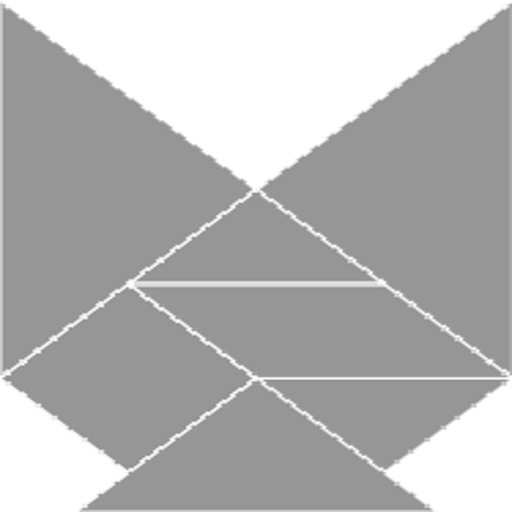

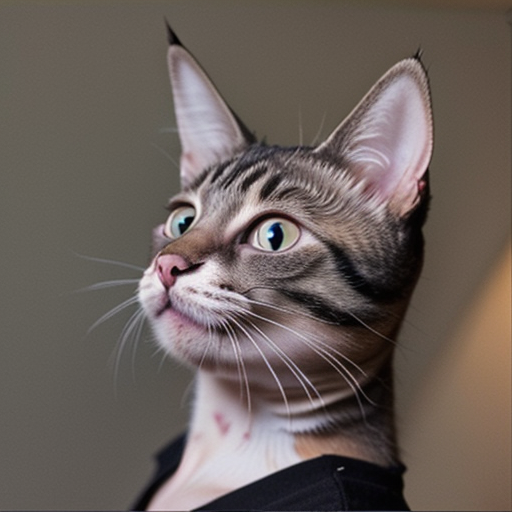

100%|██████████| 30/30 [00:01<00:00, 17.77it/s]


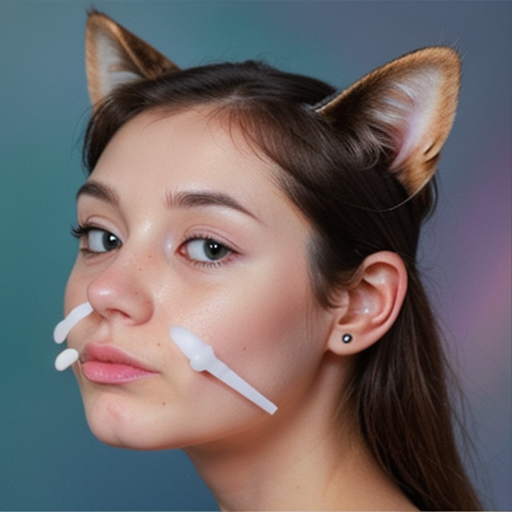

In [39]:
text_unique2 = text_part.iloc[3::5].tolist()
ind = 6

# Step 3: 加载你的七巧板结构图
control_image = Image.open(f'{tang_pth}/{keys_unique[ind]}.png').convert("RGB").resize((512, 512))

# Step 4: 提供文字标注
prompt = text_unique[ind]
prompt = f"a realistic photo of {prompt}"
# Step 5: 生成图像
image = pipe(prompt=prompt, image=control_image, num_inference_steps=30, controlnet_conditioning_scale=1.0).images[0]

# Step 6: 保存或展示
# image.save("generated_image.png")
display(control_image)
display(image)

prompt = text_unique2[ind]
prompt = f"a realistic photo of {prompt}"
image = pipe(prompt=prompt, image=control_image, num_inference_steps=30, controlnet_conditioning_scale=1.0).images[0]
display(image)

In [6]:
import pandas as pd
text_whole = df_tangram_filt['anno_whole']
text_part = df_tangram_filt['anno_parts']
keys = df_tangram_filt['key']
keys_unique = list(dict.fromkeys(keys))

In [37]:
text_unique2[ind]

'cat head with left ear, right ear, head and neck'

In [15]:
text_unique = text_whole.iloc[3::5].tolist()

# test clip feature img gen

In [3]:
from custom_pipeline_tang2 import Generator4Embeds

## params
mode = 'edge'
sub = 'sub-01'
expname = '07093-single'
directory = f"generated_imgs/sub-01-07093-single-3p"
control_scale = 0.0
n_steps = 4
# emb_eeg_test = torch.load(f'eeg_features/{expname}/ATM_S_eeg_features_sub-01_test.pt')

# 读取UNet Diffusion，把EEG Embedding转换为Image Embedding
# diffusion_prior = DiffusionPriorUNet(cond_dim=1024, dropout=0.1)
# pipe = Pipe(diffusion_prior, device=device)
# # pipe.diffusion_prior.load_state_dict(torch.load(f'/media/cyy/LENOVO_USB_HDD/EEG_Image_decode-main/Generation/fintune_ckpts/ATMS/sub-08/diffusion_prior.pt', map_location=device))
# pipe.diffusion_prior.load_state_dict(torch.load(f'/home/nncc/lyx/project/EEG_Image_decode-main/Generation/fintune_ckpts/ATMS/{sub}-{expname}/diffusion_prior.pt', map_location=device))

# generator
generator = Generator4Embeds(num_inference_steps=n_steps, controlnet_scale=control_scale, device=device, img2img_strength=0.0, cpu_offload=False)

# dataset
from eegdatasets_tang_clip2 import EEGDataset
data_path = "/home/nncc/lyx/project/EEG_Image_decode-main/myEEG/splitv3/whiten/Preprocessed_data_250Hz"
save_dir = f'dataset_features/{sub}-{expname}'
# test_dataset = EEGDataset(data_path, subjects=[sub], train=False, multilabel=True, textmode='whole', featpth=save_dir)
test_dataset = EEGDataset(data_path, subjects=[sub], train=False, multilabel=False, textmode='picture', featpth=save_dir)
texts = test_dataset.text
images = test_dataset.img

step = 1 # too much to draw

for k in tqdm(range(0, len(images), step)):
    # eeg_embeds = emb_eeg_test[k:k+1]
    # h = pipe.generate(c_embeds=eeg_embeds, num_inference_steps=10, guidance_scale=5.0)
    control_pth = f'/home/nncc/lyx/project/EEG_Image_decode-main/Generation/vae/sub-01/05-04_19-39_vae_imgs/epoch_170'
    control_pth = f'{control_pth}/reconstructed_image_{k}.png'
    control_image = process_controlimg(control_pth, mode=mode)

    for j in range(3):
        ################ img
        image = generator.generate(ip_embeds=test_dataset.img_features[k].unsqueeze(0), control_image=control_image)
        path = f'{directory}/img/{texts[k]}-{k}/{j}.png'
        os.makedirs(os.path.dirname(path), exist_ok=True)
        image.save(path)

/home/nncc/miniconda3/envs/BCI/lib/python3.10/site-packages/diffusers/utils/outputs.py:63: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(
/home/nncc/miniconda3/envs/BCI/lib/python3.10/site-packages/huggingface_hub/file_download.py:1142: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Loading pipeline components...: 100%|██████████| 7/7 [00:00<00:00, 12.72it/s]


1
self.subjects ['sub-01']
exclude_subject None
Data tensor shape: torch.Size([69, 63, 250]), label tensor shape: torch.Size([69]), text length: 69, image length: 69


100%|██████████| 69/69 [01:29<00:00,  1.30s/it]


In [5]:
images

['/home/nncc/lyx/project/EEG_Image_decode-main/myEEG/tangrams/group3_page8-213.png',
 '/home/nncc/lyx/project/EEG_Image_decode-main/myEEG/tangrams/group2_page4-177.png',
 '/home/nncc/lyx/project/EEG_Image_decode-main/myEEG/tangrams/group3_page7-28.png',
 '/home/nncc/lyx/project/EEG_Image_decode-main/myEEG/tangrams/group4_page1-13.png',
 '/home/nncc/lyx/project/EEG_Image_decode-main/myEEG/tangrams/group4_page7-10.png',
 '/home/nncc/lyx/project/EEG_Image_decode-main/myEEG/tangrams/group1_page7-133.png',
 '/home/nncc/lyx/project/EEG_Image_decode-main/myEEG/tangrams/group3_page2-105.png',
 '/home/nncc/lyx/project/EEG_Image_decode-main/myEEG/tangrams/group9_page8-188.png',
 '/home/nncc/lyx/project/EEG_Image_decode-main/myEEG/tangrams/group3_page2-105.png',
 '/home/nncc/lyx/project/EEG_Image_decode-main/myEEG/tangrams/group6_page2-16.png',
 '/home/nncc/lyx/project/EEG_Image_decode-main/myEEG/tangrams/group8_page7-121.png',
 '/home/nncc/lyx/project/EEG_Image_decode-main/myEEG/tangrams/group1_